# Description
*author:* Vina My Pham<br>
*supervisor:* Robin van der Weide<br>
*project:* MSc internship project<br>
<br>
*date:* January 15 - July 26, 2024<br>
*host:* Kind group, Hubrecht Institute<br>
*university:* Bioinformatics, Wageningen University & Research<br>

---
Notebook to analyse 3D nuclear predictions in combination with detected 3D spots

---
**Input**<br>
- img_matrix_path: path to .TIF of the confocal stack
- nucleus_matrix_path: path to .TIF of 3D nuclei labels
- chromocenter_matrix_path: path to .TIF of 3D spot labels

#Notebook initialisation

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [ ]:
#util
import os
import copy
from datetime import datetime
from collections import Counter

#data structure
import numpy as np
import pandas as pd
import skimage

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

#output
import pickle
import json
import tifffile

## Custom class

In [ ]:
class SegmentedStack:
    """
    A class representing a segmented stack containing image, nucleus, and chromocenter matrices.

    Attributes:
        name (str): Arbitrary identifier of the segmented stack

        img_matrix (np.ndarray): 4D image matrix
        nucleus_matrix (np.ndarray): 3D nucleus matrix
        chromocenter_matrix (np.ndarray): 3D chromocenter matrix

        nucleus_ids (list): list of nucleus IDs
        chromocenter_ids (list): list of chromocenter IDs

        thresholded_cc_nuclei_matches (dict): thresholded chromocenter-nuclei matches
        cc_n_nucleus_matches (dict): chromocenter-nucleus matches
        cc_overview (dict): Overview of chromocenters

        nucleus_dict (dict): Dictionary containing nucleus information
        nucleus_overview (dict): Overview of nuclei

        filtering: Metadata for filtering

    Methods:
        __repr__: Return 'SegmentedStack(<name>)' when object is called
    """
    def __init__(self, name, img_matrix = None, nucleus_matrix = None, chromocenter_matrix = None):
        """
        Initialize SegmentedStack with matrices and name.

        Args:
            name (str): The name of the segmented stack.
            img_matrix (np.ndarray, optional): 4D image matrix. Default: None
            nucleus_matrix (np.ndarray, optional): 3D nucleus matrix.
                                                Default: None
            chromocentre_matrix (np.ndarray, optional): 3D chromocentre matrix.
                                                        Default: None
        """
        self.name = name #str

        #MATRICES info - developer note: would be nicer if this is a class
        self.img_matrix = img_matrix #4D np array
        self.nucleus_matrix = nucleus_matrix #3D np array
        self.chromocenter_matrix = chromocenter_matrix #3D np array

        #CC info - developer note: would be nicer if this is a class
        self.thresholded_cc_nuclei_matches = None
        self.cc_n_nucleus_matches = None
        self.cc_overview = None

        #NUCLEI info - developer note: would be nicer if this is a class
        self.nucleus_dict = None
        self.nucleus_overview = None

        #METADATA
        self.filtering = None

    def __repr__(self):
        """Return 'SegmentedStack(<name>)' if object is called
        """
        return f"SegmentedStack({self.name})"

    def nucleus_ids(self):
        nucleus_ids = []

        if isinstance(self.nucleus_matrix, np.ndarray):
            nucleus_ids = list(np.unique(self.nucleus_matrix))
            if 0 in nucleus_ids:
                nucleus_ids.remove(0)

        return nucleus_ids

    def chromocenter_ids(self):
        chromocenter_ids = []

        if isinstance(self.chromocenter_matrix, np.ndarray):
            chromocenter_ids = list(np.unique(self.chromocenter_matrix))
            if 0 in chromocenter_ids:
                chromocenter_ids.remove(0)

        return chromocenter_ids

class Nucleus:
    """Class for storing chromocenter data per nucleus

    Attr:
        nucleus_id
        perfect_cc_ids
        partial_cc_ids
        n_chromocenters
    """
    def __init__(self, nucleus_id, perfect_cc_ids = [], partial_cc_ids = []):
        self.nucleus_id = nucleus_id

        self.perfect_cc_ids = perfect_cc_ids
        self.partial_cc_ids = partial_cc_ids

        self.n_chromocenters = len(perfect_cc_ids) #+ len(partial_cc_ids)


## Custom functions

### matching

In [ ]:
def detect_nuclei_for_cc(segmentedstack, verbose=False):
    """Detects and counts nuclei associated with each chromocenter

    Args:
        segmentedstack (SegmentedStack Object):
        An object representing the segmented image stack, which contains methods `chromocenter_ids()`
        to get the IDs of chromocenters, and `chromocenter_matrix` and `nucleus_matrix` attributes
        representing the segmented chromocenters and nuclei respectively.

        verbose (bool): whether to print verbose. Default: false.

    Returns:
        dict - key (int) : chromocentre IDs.
               value (Counter) : nucleus IDs that overlap with the chromocentre
                                and their occurences.
    """

    print(f"{datetime.now()}\tProcessing {timepoint}")

    cc_nuclei_pairing = {} #chromocenter_id : {nucleus_id : count}

    for cc_i, chromocenter_id in enumerate(segmentedstack.chromocenter_ids()):
        if verbose: print(f"\r\tProcessing chromocenter id {chromocenter_id} ({cc_i/len(segmentedstack.chromocenter_ids())*100:.2f}%)", end="")

        #get the Z coordinates
        chromocenter_iplanes = get_iplanes(segmentedstack.chromocenter_matrix, chromocenter_id)

        detected_nuclei_ids = []

        #loop through Z
        for z_i, iplane in enumerate(chromocenter_iplanes,1):
            #if verbose: print(f"plane id: {iplane} ({z_i/len(chromocenter_iplanes)*100:.2f}%)", end="", flush=True)

            #find overlap coordinates of chromocenter in nucleus matrix
            coords_in_chromocenter_matrix = get_mask_px_coords(segmentedstack.chromocenter_matrix[iplane, :,:], chromocenter_id) #[[X Y], [X Y], ...]
            nuclei_ids_in_chromocenter_region = get_mask_ids_from_coords(segmentedstack.nucleus_matrix[iplane, :,:], coords_in_chromocenter_matrix, unique=False)
            detected_nuclei_ids += nuclei_ids_in_chromocenter_region
            if verbose: print(f"\nnuclei_ids_in_chromocenter_region in plane {iplane}: ", nuclei_ids_in_chromocenter_region)
            if verbose: print(f"detected_nuclei_ids:", detected_nuclei_ids)
            #if z_i==10: break #plane loop

        #if verbose: print('\n\tcounter detected_nuclei_ids: ', Counter(detected_nuclei_ids)) #{nucleus_id : count}

        cc_nuclei_pairing[chromocenter_id] = Counter(detected_nuclei_ids)
        #if cc_i == 3: break #cc loop

    print(f"\n{datetime.now()}\tFinished processing {timepoint}")
    return cc_nuclei_pairing

### mask_properties

In [ ]:
def get_mask_px_coords(mask_matrix, mask_id):
    """Get pixel coordinates with specified mask ID in a 2D/3D matrix

    Args:
        mask_matrix (np.ndarray): mask matrix of one plane or a full stack
            2D shape: nY x nX
            3D shape: nPlanes x nY x nX
        mask_id (int): ID of the mask to retrieve pixel coordinates.

    Returns:
        np.ndarray: Array of pixel coordinates where the mask is present
            nested arrays of 2 elements (or 3 if 3D) - 2D: (Y, X)
                                                       3D: (plane id, Y, X)
    """
    mask = copy.deepcopy(mask_matrix)
    mask[~np.isin(mask,[mask_id])] = 0
    return np.transpose(np.nonzero(mask))

def get_iplanes(mask_matrix, mask_id):
    """Get planes in which the mask id is present in a 3D matrix

    Args:
        mask_matrix (np.ndarray): 3D mask matrix
        mask_id (int): ID of the mask to search for

    Returns:
        list of ints - plane indices where the mask is present, sorted in
                       ascending order
    """
    planes = []
    for iplane in range(mask_matrix.shape[0]):
        if mask_id in mask_matrix[iplane,:,:]:
            planes.append(iplane)
    return sorted(planes)

def get_mask_ids_from_coords(plane_mask_matrix, px_coords, unique=True):
    """Get unique mask IDs from specified pixel coordinates in a 2D matrix

    Args:
        2d_plane_mask_matrix (np.ndarray): 2D mask matrix of a single plane
        px_coords (list): list of pixel coordinates
        unique (bool, optional): if True, retain unique ids;
                                 if False, duplicates are included
                                 Default: True

    Returns:
        list - mask IDs at the specified pixel coordinates.
    """
    mask_ids = np.array([plane_mask_matrix[px_coord[0], px_coord[1]]
                         for px_coord in px_coords])

    mask_ids = list(mask_ids)
    if unique:
        mask_ids = list(np.unique(mask_ids))
    return mask_ids

def get_area_per_plane(mask_id, mask_matrix):
    """ Calculates the area of a specific mask in each plane of a 3D mask matrix.

    Args:
    mask_id (int) : mask id
    mask_matrix (numpy.ndarray): A 3D numpy array representing the mask matrix
                                [Z, X, Y]

    Returns:
        list of tup(int, int): (iplane, area of mask in iplane)
    """
    mask_iplanes = get_iplanes(mask_matrix, mask_id)

    mask_pxs=[]
    for iplane in mask_iplanes:
        mask_px = get_mask_px_coords(mask_matrix[iplane, :, :], mask_id)

        #print(iplane, len(mask_px))
        mask_pxs.append((iplane, len(mask_px)))

    return mask_pxs

### statistics

In [ ]:
def calculate_jaccard(reference_list, compare_list):
    """Calculate jaccard index between two sets of coordinates.

    Args:
        reference_list (list): np.array of arrays - coordinates for reference
        compare_list (list): np.array of arrays - coordinates for comparison

    Returns:
        0. list of tuples: Tuples both lists have in common (intersection)
        1. list of tuples: All unique tuples in both lists (union)
        2. list of floats: jaccard index (intersection/union)
    """
    reference_tuples = list(map(tuple, reference_list))
    compare_tuples = list(map(tuple, compare_list))
    intersection = set(reference_tuples).intersection(set(compare_tuples))
    union = set(reference_tuples).union(set(compare_tuples))
    jaccard = len(intersection) / len(union)
    return intersection, union, jaccard

### visualisation

In [ ]:
import cv2
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    #print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from " +
    #      "cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>4:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px

def imgs_to_avi(video_name, in_dir, framerate):
    #data retrieval
    image_folder = in_dir
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])

    #initialise gif settings
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 1196444237, framerate, (width,height))

    #create gif
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    #save
    cv2.destroyAllWindows()
    video.release()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
#https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
redmap = LinearSegmentedColormap.from_list(
        "Black2Red", colors, N=100)

colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is green
greenmap = LinearSegmentedColormap.from_list(
        "Black2Green", colors, N=100)

colors = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
bluemap = LinearSegmentedColormap.from_list(
        "Black2Blue", colors, N=100)

rgb_map = {0:redmap, 1:greenmap, 2:bluemap}

# File loading

In [ ]:
#@markdown **Provide paths to the input files (.TIF)**
img_matrix_path = "" #@param {type:"string"}
nucleus_matrix_path = "" #@param {type:"string"}
chromocenter_matrix_path = "" #@param {type:"string"}

#@markdown **Provide the resolution (i.e. voxel volume).**
volume_scale = 0.11*0.11*0.05 #@param

#data loading
img_matrix = skimage.io.imread(img_matrix_path)
nucleus_matrix = skimage.io.imread(nucleus_matrix_path)
chromocenter_matrix = skimage.io.imread(chromocenter_matrix_path)

#report
print("--SHAPES--")
print("img_matrix.shape (Z*X*Y*channels): ", img_matrix.shape)
print("nucleus_matrix.shape (Z*X*Y): ", nucleus_matrix.shape)
print("chromocenter_matrix.shape (Z*X*Y): ", chromocenter_matrix.shape)
print("volume_scale: ", volume_scale)

# Additional filtering

- removing nucleus and chromocentre IDs based on inspection of 3D mask statistics (filter_3Dmasks.ipynb)

### Removal of masks from matrices and cc_nuclei_matches
text file structure:

0. comment line (filter mode)
1. header
2+. tab-delimited;
        0. name
        1. label_path
        2. ids_to_remove

In [ ]:
nuclei_filter_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/06_QC_matrices/overview_removal_nuclei.txt" #@param {type:"string"}
chromocenter_filter_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/06_QC_matrices/overview_removal_cc.txt" #@param {type:"string"}

filter_nuclei=True #@param {type:"boolean"}
filter_chromocenters=True #@param {type:"boolean"}

#get ids_to_remove from the files
if filter_nuclei:
    print('--NUCLEI--')
    with open(nuclei_filter_path, 'r') as nuclei_filter_obj:
        nuclei_filters = nuclei_filter_obj.readlines()[2:] #skip header

    for line in nuclei_filters:
        #parse row
        name, label_path, ids_to_remove = line.strip().split("\t")
        if timepoint in name: #relevant line detected
            print(f"getting info from line with name '{name}'")
            nuclei_ids_to_remove = eval(ids_to_remove) #turn into a list
            break

    print(f"n IDs to be removed from the nucleus_matrix = {len(nuclei_ids_to_remove)}")


if filter_chromocenters:
    print('\n--CHROMOCENTERS--')
    with open(chromocenter_filter_path, 'r') as chromocenter_filter_obj:
        chromocenter_filters = chromocenter_filter_obj.readlines()[2:] #skip header

    for line in chromocenter_filters:
        #parse row
        name, label_path, ids_to_remove = line.strip().split("\t")

        if timepoint in name:
            print(f"getting info from line with name '{name}'")
            cc_ids_to_remove = eval(ids_to_remove) #turn into a list
            break

    print(f"n IDs to remove from the chromocenter_matrix = {len(cc_ids_to_remove)}")



--NUCLEI--
getting info from line with name 'SPE20230317_D40_nuclei'
n IDs to be removed from the nucleus_matrix = 10

--CHROMOCENTERS--
getting info from line with name 'SPE20230317_D40_DAPI'
n IDs to remove from the chromocenter_matrix = 1242


In [ ]:
#remove from matrices
if filter_nuclei:
    nucleus_matrix[np.isin(nucleus_matrix, nuclei_ids_to_remove)] = 0
    print(f"\tIDs have been removed from the nucleus_matrix (n={len(nuclei_ids_to_remove)})")

if filter_chromocenters:
    chromocenter_matrix[np.isin(chromocenter_matrix, cc_ids_to_remove)] = 0
    print(f"\tIDs have been removed from the chromocenter_matrix (n={len(cc_ids_to_remove)})")

	IDs have been removed from the nucleus_matrix (n=10)
	IDs have been removed from the chromocenter_matrix (n=1242)


In [ ]:
#remove CC ids
for cc_id in cc_ids_to_remove:
    del cc_nuclei_matches[cc_id]

#remove nucleus IDs
print('Overview of detected nucleus_id matches that have been removed:')
for cc_id, nucleus_count in cc_nuclei_matches.items():
    edit_nucleus_ids = [nucleus_id for nucleus_id in nucleus_count.keys() if nucleus_id in nuclei_ids_to_remove]
    for nucleus_id in edit_nucleus_ids:
            print(f'\tnucleus_id {nucleus_id} in cc_id {cc_id}.')

            #get stored count and delete entry
            stored_nucleus_count = nucleus_count.get(nucleus_id)
            del nucleus_count[nucleus_id]

            #add to background
            original_bg_count = nucleus_count.get(0, 0) #if not matched to bg, then return 0
            nucleus_count[0] = original_bg_count + stored_nucleus_count

print("\n(if empty: none of the nucleus ids matched with a CC.)")

Overview of detected nucleus_id matches that have been removed:
	nucleus_id 594 in cc_id 346.
	nucleus_id 390 in cc_id 788.
	nucleus_id 404 in cc_id 9181.
	nucleus_id 404 in cc_id 9649.
	nucleus_id 594 in cc_id 16488.

(if empty: none of the nucleus ids matched with a CC.)


#Store the masks of the timepoint in a SegmentedStack object

In [ ]:
segmentedstack = SegmentedStack(timepoint, img_matrix, nucleus_matrix, chromocenter_matrix)

# Finding nuclei ID for CCs

**Description:**

Codeblock for comparing the chromocenter label matrix with the nucleus label matrix.
- Useful for assessing segmentation quality
- Used to assign CCs to nuclei for downstream classification.


---

**Input:**
- `cc_nuclei_matches_path` : path to a `cc-nucleus_match.json` file (if you're continuing with a previous session.) If left empty, the block will run the `detect_nuclei_for_cc()` function and create a new `cc-nucleus_match.json` file.

**Returns:**


## Detecting nuclei_IDs for each CC_id

In [ ]:
#@markdown [code: create cc_nuclei_matches]
if len(cc_nuclei_matches_path) > 0:
    with open(cc_nuclei_matches_path, 'r') as cc_nuclei_matches_obj:
        cc_nuclei_matches = json.load(cc_nuclei_matches_obj) #{ str(cc_id) : {str(nucleus_id) : count}}
        cc_nuclei_matches = {int(cc_id) : {int(nucleus_id) : int(count) for nucleus_id, count in nuclei_count.items()} for cc_id, nuclei_count in cc_nuclei_matches.items()}
    print(f'loaded cc_nuclei_matches from {cc_nuclei_matches_path}')
else:
    cc_nuclei_matches = detect_nuclei_for_cc(segmentedstack, verbose=True)

    #write to file after serialising the dictionary
    cc_nuclei_matches = {int(cc_id) : {int(nucleus_id) : int(count) for nucleus_id, count in nuclei_count.items()} for cc_id, nuclei_count in cc_nuclei_matches.items()}
    file_path = f"/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/multi_otsu/{timepoint}_cc-nucleus_match.json"
    with open(file_path, "w") as json_file:
        json.dump(cc_nuclei_matches, json_file)



loaded cc_nuclei_matches from /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/multi_otsu/D25_cc-nucleus_match.json


### General stats


In [ ]:
#@markdown [print n nuclei and chromocenters, estimation avg n CC per nucleus]
print(f"--STATS for {timepoint}--")
print("n nuclei: ", len(segmentedstack.nucleus_ids()))
print("n chromocenters: ", len(segmentedstack.chromocenter_ids()))

print("estimate average n chromocenter per nucleus: ", len(segmentedstack.chromocenter_ids())/len(segmentedstack.nucleus_ids()))

--STATS for D25--
n nuclei:  558
n chromocenters:  1959
estimate average n chromocenter per nucleus:  3.510752688172043


#Plotting distribution

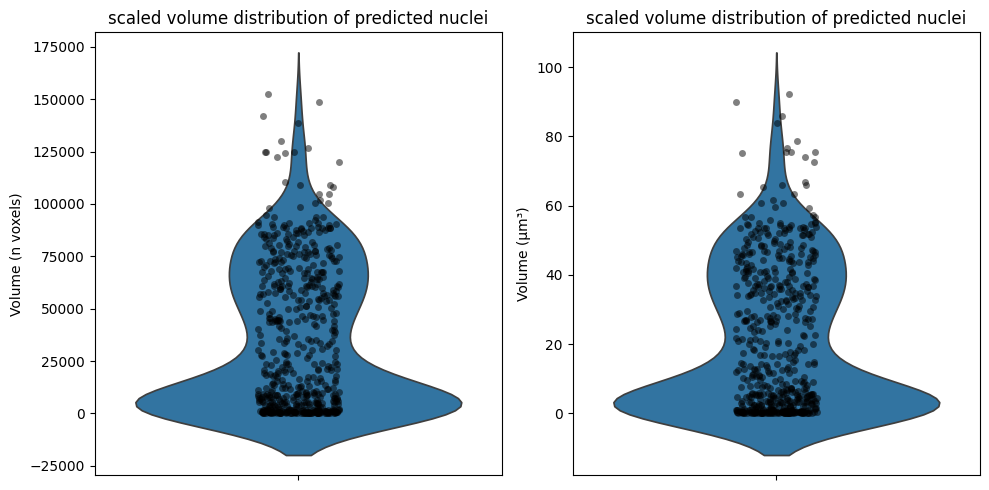

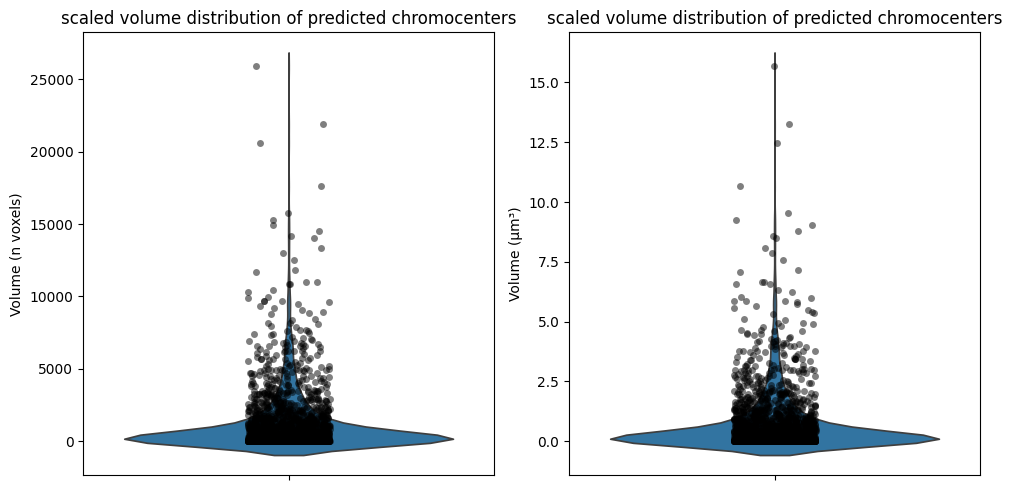

In [ ]:
#@markdown [plot distribution of nucleus and chromocentre volume]
#data retrieval
_, nucleus_volumes = np.unique(nucleus_matrix, return_counts=True)
nucleus_volumes = nucleus_volumes[1:] #assumes first element is for background

_, chromocentre_volumes = np.unique(chromocenter_matrix, return_counts=True)
chromocentre_volumes = chromocentre_volumes[1:] #assumes first element is for background

#plot
for element, volumes in zip(["nuclei", "chromocenters"],
                            [nucleus_volumes, chromocentre_volumes]):
    plt.figure(figsize=(10,5))

    #plot volume in number of voxels
    plt.subplot(1,2,1)
    sns.violinplot(volumes, inner=None)
    sns.stripplot(volumes, color="black", alpha=0.5)
    plt.xlabel('')
    plt.ylabel('Volume (n voxels)')
    plt.title(f'scaled volume distribution of predicted {element}')

    #plot volume in scaled equivalent
    plt.subplot(1,2,2)
    sns.violinplot(volumes*volume_scale, inner=None)
    sns.stripplot(volumes*volume_scale, color="black", alpha=0.5)
    plt.xlabel('')
    plt.ylabel('Volume (μm³)')
    plt.title(f'scaled volume distribution of predicted {element}')

    plt.tight_layout()
    plt.show()


n CC under 30 voxels = 483 (24.66%)


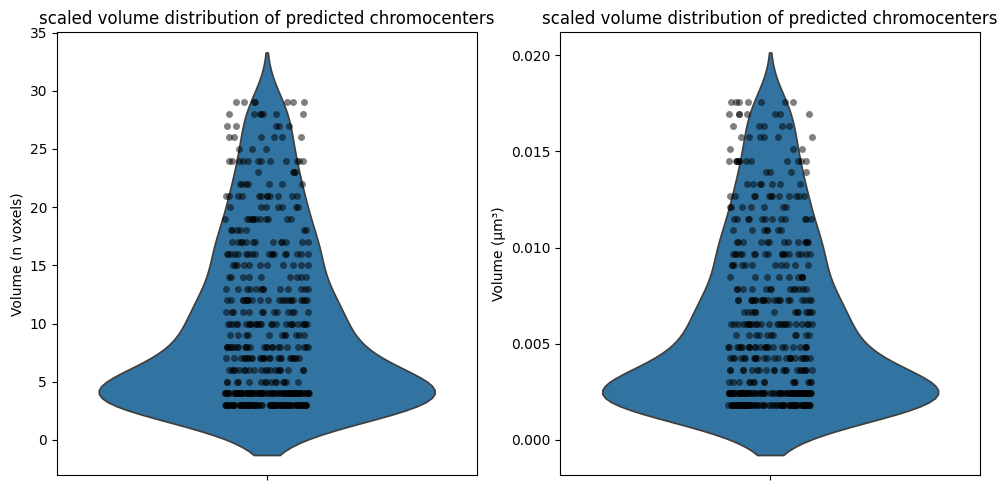

In [ ]:
#@markdown [plot distribution of chromocentre volume under a threshold]
min_volume = 30 #@param {type:"number"}
as_scaled=False #@param {type:"boolean"}
if as_scaled:
    min_volume = min_volume / volume_scale

#data retrieval
sub_chromocentre_volumes = [volume for volume in chromocentre_volumes if volume < min_volume]
print(f"n CC under {min_volume} {'μm³' if as_scaled else 'voxels'} = {len(sub_chromocentre_volumes)} ({len(sub_chromocentre_volumes) / len(chromocentre_volumes) * 100:.2f}%)")

#plot
for element, volumes in zip(["chromocenters"],
                            [sub_chromocentre_volumes]):

    scaled_volumes = [_*volume_scale for _ in volumes]

    plt.figure(figsize=(10,5))

    #plot volume in number of voxels
    plt.subplot(1,2,1)
    sns.violinplot(volumes, inner=None)
    sns.stripplot(volumes, color="black", alpha=0.5)
    plt.xlabel('')
    plt.ylabel('Volume (n voxels)')
    plt.title(f'scaled volume distribution of predicted {element}')

    #plot volume in scaled equivalent
    plt.subplot(1,2,2)
    sns.violinplot(scaled_volumes, inner=None)
    sns.stripplot(scaled_volumes, color="black", alpha=0.5)
    plt.xlabel('')
    plt.ylabel('Volume (μm³)')
    plt.title(f'scaled volume distribution of predicted {element}')

    plt.tight_layout()
    plt.show()

# Analysing segmentation quality (CC-based)

**Description:**

---

**Input:**

**Returns:**


### perfect CC matches (100% one nucleus_id or bg)

**output**
- `ccs_inside_one_nucleus`: list of ints - cc_ids
> 100% overlap with one nucleus ID
- `ccs_outside_nucleus`: list of ints - cc_ids
> 100% overlap with background of nucleus_matrix.

### Thresholding for spillage

In [ ]:
#@markdown [code: ccs_outside_nucleus, ccs_inside_one_nucleus]
ccs_outside_nucleus = [] #list of ints - cc_ids
ccs_inside_one_nucleus = []  #list of ints - cc_ids

for cc, nucleus_count in cc_nuclei_matches.items():
    if len(nucleus_count) == 1: #100% match

        if list(nucleus_count.keys()) == [0]: #100% overlap with bg
            ccs_outside_nucleus.append(cc)

        else: #100% overlap with nucleus
            ccs_inside_one_nucleus.append(cc)

print("--STATS FOR 100% MATCHES--")
print(f"n CC that have 1 predicted nucleus: {len(ccs_inside_one_nucleus)} ({len(ccs_inside_one_nucleus)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t[code: len(ccs_inside_one_nucleus) (matched id !=0)]")
print(f"n CC that have no predicted nucleus: {len(ccs_outside_nucleus)} ({len(ccs_outside_nucleus)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t[code: len(ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]")

_ = len(segmentedstack.chromocenter_ids()) - len(ccs_inside_one_nucleus) - len(ccs_outside_nucleus)
print(f"n CC that have multiple predicted nuclei (incl bg): {_} ({_/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]")

print(f"\ntotal n: {len(ccs_inside_one_nucleus)+len(ccs_outside_nucleus)+_}")

--STATS FOR 100% MATCHES--
n CC that have 1 predicted nucleus: 1261 (64.37%)		[code: len(ccs_inside_one_nucleus) (matched id !=0)]
n CC that have no predicted nucleus: 121 (6.18%)		[code: len(ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]
n CC that have multiple predicted nuclei (incl bg): 577 (29.45%)	[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]

total n: 1959


In [ ]:
min_spillage_thr = 25 #@param {type:"integer"}
#@markdown note: if `as_percentage` is NOT selected, chromocentres are also filtered based on number of pixels (volume)
as_percentage = True #@param {type:"boolean"}

#_FILTER
thresholded_cc_nuclei_matches = {}

for cc_id, nucleus_count in cc_nuclei_matches.items():
    if len(nucleus_count) >= 2: #check which surpass the thresholod

        if as_percentage:
            nucleus_count_passed_thr = {nucleus_id : count for nucleus_id, count in nucleus_count.items() if count >= sum(list(nucleus_count.values()))*(min_spillage_thr/100)}
        else: #take absolute n pixels
            nucleus_count_passed_thr = {nucleus_id : count for nucleus_id, count in nucleus_count.items() if count >= min_spillage_thr}

        thresholded_cc_nuclei_matches[cc_id] = nucleus_count_passed_thr

    else:
        thresholded_cc_nuclei_matches[cc_id] = nucleus_count

#_UPDATING 1:1 MATCHES
thresholded_ccs_outside_nucleus = copy.deepcopy(ccs_outside_nucleus)
thresholded_ccs_inside_one_nucleus = copy.deepcopy(ccs_inside_one_nucleus)

for cc_id, n_nucleus_matches in thresholded_cc_nuclei_matches.items():
    if len(n_nucleus_matches) == 1:

        if list(n_nucleus_matches.keys()) == [0]: #match with bg
            if cc_id not in ccs_outside_nucleus: #passed the threshold
                thresholded_ccs_outside_nucleus.append(cc_id)

        else: #match with nucleus
            if cc_id not in ccs_inside_one_nucleus: #passed the threshold
                thresholded_ccs_inside_one_nucleus.append(cc_id)

print("--STATS FOR THRESHOLDED 1:1 MATCHES--")
print(f"n CC that lie within 1 predicted nucleus: {len(thresholded_ccs_inside_one_nucleus)} ({len(thresholded_ccs_inside_one_nucleus)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t\t\t\t[code: len(thresholded_ccs_inside_one_nucleus) (matched id !=0)]")
print(f"n CC without any match to predicted nucleus: {len(thresholded_ccs_outside_nucleus)} ({len(thresholded_ccs_outside_nucleus)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t\t\t\t[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]")

imperfect_cc = [cc_id for cc_id in segmentedstack.chromocenter_ids() if cc_id not in thresholded_ccs_inside_one_nucleus and cc_id not in thresholded_ccs_outside_nucleus]
print(f"n CC that lie within multiple predicted nuclei (incl bg): {len(imperfect_cc)} ({len(imperfect_cc)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t\t\t[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]")

print(f"\ntotal n: {len(thresholded_ccs_inside_one_nucleus)+len(thresholded_ccs_outside_nucleus)+len(imperfect_cc)}")

--STATS FOR THRESHOLDED 1:1 MATCHES--
n CC that lie within 1 predicted nucleus: 1658 (84.64%)					[code: len(thresholded_ccs_inside_one_nucleus) (matched id !=0)]
n CC without any match to predicted nucleus: 153 (7.81%)					[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]
n CC that lie within multiple predicted nuclei (incl bg): 148 (7.55%)				[code: len(thresholded_ccs_outside_nucleus) (outside of nucleus = 0 is the only matched nucleus ID)]

total n: 1959


### Spilled CC (continuing with thresholded counts.)

**output**

- `spilled_ccs`: list of ints - cc_ids
> overlap with multiple nucleus IDs (including background)

In [ ]:
#@markdown [code: spilled_ccs]
spilled_ccs = [] #list of ints - cc_ids

for cc, nucleus_count in thresholded_cc_nuclei_matches.items():
    if len(nucleus_count) >= 2:
        spilled_ccs.append(cc)

#@markdown [code: spilled_ccs_backgroundmatch]
spilled_ccs_backgroundmatch = [] #list of ints - cc_ids

for spilled_cc_id in spilled_ccs:
    nucleus_count = thresholded_cc_nuclei_matches[spilled_cc_id] # {nucleus_id : count}

    if 0 in nucleus_count.keys(): # chromocenter partially matched with background
        spilled_ccs_backgroundmatch.append(spilled_cc_id)

#REPORTING
print(f"--STATS FOR min_spillage_thr = {min_spillage_thr}--")
print(f"n CC that are not completely encapsulated in one predicted nucleus: {len(spilled_ccs)} ({len(spilled_ccs)/len(segmentedstack.chromocenter_ids())*100:.2f}%)\t\t\t[code: len(spilled_ccs) (spilled = len(nucleus_count) >= 2) - % of chromocenter_ids]")
print(f"n spilled CC that partially matched with background: {len(spilled_ccs_backgroundmatch)} ({len(spilled_ccs_backgroundmatch)/len(spilled_ccs)*100:.2f}%)\t\t\t\t\t[code: len(spilled_ccs_backgroundmatch) (detected 0 in the nucleus_ids list) - % of spilled_ccs]")
print()

--STATS FOR min_spillage_thr = 25--
n CC that are not completely encapsulated in one predicted nucleus: 148 (7.55%)			[code: len(spilled_ccs) (spilled = len(nucleus_count) >= 2) - % of chromocenter_ids]
n spilled CC that partially matched with background: 107 (72.30%)					[code: len(spilled_ccs_backgroundmatch) (detected 0 in the nucleus_ids list) - % of spilled_ccs]



## Distribution of nuclei with (im)perfect predicted CCs

**Description:**

---

**Input:**

**Returns:**


In [ ]:
#@markdown [nucleus_dict {nucleus_id : NucleusObj}]
verbose=False

nucleus_dict = {} #nucleus_id : Nucleus obj

#loop through nucleus_id
for nucleus_id in segmentedstack.nucleus_ids():

    #find CCs inside of the nucleus
    perfect_cc_ids = [cc_id for cc_id in thresholded_ccs_inside_one_nucleus if list(thresholded_cc_nuclei_matches[cc_id].keys()) == [nucleus_id]]
    partial_cc_ids = [cc_id for cc_id in spilled_ccs if nucleus_id in list(thresholded_cc_nuclei_matches[cc_id].keys())]

    #store data
    nucleus_obj = Nucleus(nucleus_id,
                          perfect_cc_ids = perfect_cc_ids,
                          partial_cc_ids = partial_cc_ids)
    nucleus_dict[nucleus_id] = nucleus_obj

    #verbose, dev
    if verbose:
        print("nucleus_id: ", nucleus_id)
        print("perfect_cc_ids", perfect_cc_ids)
        print("partial_cc_ids", partial_cc_ids)

In [ ]:
#@markdown [code: nuclei_with_`match_type`_cc]
dev=False
max_i = 5 #for code development.

#init
nuclei_with_no_predicted_cc = []
nuclei_with_all_perfect_cc = []
nuclei_with_perfect_and_partial_cc = []
nuclei_with_all_partial_cc = []

#process
for i, nucleus_id in enumerate(segmentedstack.nucleus_ids(), 1):

    n_perfect_cc = len(nucleus_dict[nucleus_id].perfect_cc_ids)
    n_partial_cc = len(nucleus_dict[nucleus_id].partial_cc_ids)

    if [n_perfect_cc, n_partial_cc] == [0,0]:
        nuclei_with_no_predicted_cc.append(nucleus_id)
    elif n_perfect_cc > 0 and n_partial_cc == 0:
        nuclei_with_all_perfect_cc.append(nucleus_id)
    elif n_perfect_cc > 0 and n_partial_cc > 0:
         nuclei_with_perfect_and_partial_cc.append(nucleus_id)
    elif n_perfect_cc == 0 and n_partial_cc > 0:
        nuclei_with_all_partial_cc.append(nucleus_id)

    if dev:
        print("[nucleus_id, n_perfect_cc, n_partial_cc]\t\t", [nucleus_id, n_perfect_cc, n_partial_cc])
        print()
        if i == max_i: break

print("--REPORT--")
print(f"nuclei_with_no_predicted_cc\t\t(n = {len(nuclei_with_no_predicted_cc)})\t",  nuclei_with_no_predicted_cc)
print(f"nuclei_with_all_perfect_cc\t\t(n = {len(nuclei_with_all_perfect_cc)})\t", nuclei_with_all_perfect_cc)
print(f"nuclei_with_perfect_and_partial_cc\t(n = {len(nuclei_with_perfect_and_partial_cc)})\t", nuclei_with_perfect_and_partial_cc)
print(f"nuclei_with_all_partial_cc\t\t(n = {len(nuclei_with_all_partial_cc)})\t", nuclei_with_all_partial_cc)
print()

--REPORT--
nuclei_with_no_predicted_cc		(n = 222)	 [1, 8, 25, 54, 63, 69, 84, 85, 98, 116, 141, 158, 159, 160, 165, 166, 170, 175, 177, 179, 182, 187, 189, 201, 204, 208, 211, 212, 224, 225, 226, 237, 240, 245, 252, 255, 258, 260, 261, 263, 265, 273, 279, 281, 283, 285, 289, 291, 293, 296, 298, 301, 306, 309, 319, 329, 339, 340, 345, 355, 358, 359, 360, 362, 364, 369, 374, 377, 380, 383, 386, 388, 391, 398, 399, 400, 411, 418, 425, 435, 444, 450, 454, 458, 460, 461, 462, 464, 468, 470, 472, 484, 485, 486, 489, 490, 494, 495, 498, 499, 501, 502, 503, 504, 505, 508, 512, 518, 528, 529, 533, 535, 536, 538, 541, 542, 547, 552, 554, 559, 563, 568, 569, 571, 572, 582, 588, 589, 592, 610, 613, 614, 645, 648, 649, 657, 668, 673, 675, 676, 681, 683, 684, 686, 690, 693, 700, 701, 704, 706, 707, 715, 738, 740, 741, 742, 751, 753, 758, 761, 771, 775, 781, 782, 789, 790, 807, 809, 812, 821, 827, 836, 838, 846, 855, 856, 858, 863, 867, 874, 877, 879, 881, 882, 884, 890, 892, 902, 904, 906, 907, 908,

#Visualisation summary

## CC: n nucleus matches

In [1]:
#@markdown [code: barplot - the number of nuclei a CC was matched in]
#visualisation option
# @ markdown **how big the gap between text and bar should be**
margin = 0.01 #@param {type:"number"}
y_increase = 75 #@param {type:"number"}

#get distribution
cc_n_nucleus_matches = {cc_id : len(nucleus_count) for cc_id, nucleus_count in thresholded_cc_nuclei_matches.items()}

for cc_id in thresholded_ccs_outside_nucleus: #include 100% with bg as "0 nucleus match"
    cc_n_nucleus_matches[cc_id] = 0

value_counts = Counter(cc_n_nucleus_matches.values()) #{n nucleus matches : count}
value_counts = dict(sorted(value_counts.items())) #sorted by n nucleus_matches, ascending

#plot (x: n nucleus match, y: count)
x = range(len(value_counts.keys()))
y = list(value_counts.values())
total = sum(y)

plt.bar(x, y)
plt.ylim(0, max(y) + y_increase)  # adjust y-axis limits so that text fits nicely
plt.xticks(x)
plt.xlabel('n predicted nucleus matches')
plt.ylabel('n')
plt.title(f'distribution of n nucleus matches - {timepoint} (n CC = {len(segmentedstack.chromocenter_ids())})\nmin_spillage_thr = {min_spillage_thr}{"%" if as_percentage else ""}')

for i in x: #plotting percentage on top of bar
    plt.text(x[i], y[i] + margin*total, f'{y[i]}\n({y[i]/total:.2%})', ha='center')

plt.show()

NameError: name 'thresholded_cc_nuclei_matches' is not defined

## nuclei: n matches per type

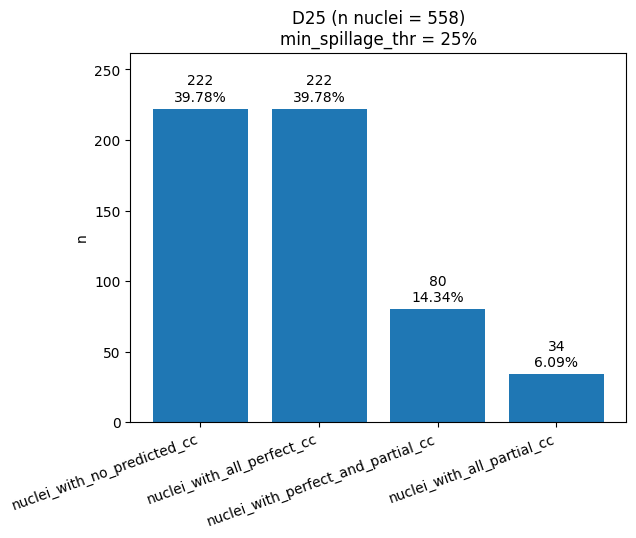

In [ ]:
#@markdown [code: plot number of nuclei with 0 CC, all perfect CC, perfect+partial, all partial]
#visualisation options
#@markdown **how big the gap between text and bar should be**
margin=0.01 #@param {type:"number"}
y_increase = 40 #@param {type:"number"}

#data
xlabels = ["nuclei_with_no_predicted_cc", "nuclei_with_all_perfect_cc", "nuclei_with_perfect_and_partial_cc", "nuclei_with_all_partial_cc"]
x = range(len(xlabels))
y = [len(nuclei_with_no_predicted_cc), len(nuclei_with_all_perfect_cc), len(nuclei_with_perfect_and_partial_cc), len(nuclei_with_all_partial_cc)]
total = sum(y)

#plot
plt.bar(x, y)
plt.ylim(0, max(y) + y_increase)  # adjust y-axis limits so that text fits nicely
for i in x: #plotting percentage on top of bar
    plt.text(x[i], y[i] + margin*total, f'{y[i]}\n{y[i]/total:.2%}', ha='center')
plt.xticks(x, rotation=20, ha='right', labels=xlabels)
#plt.xlabel('<nuclei match type..>')
plt.ylabel('n')
plt.title(f"{timepoint} (n nuclei = {len(segmentedstack.nucleus_ids())})\nmin_spillage_thr = {min_spillage_thr}{'%' if as_percentage else ''}");

# Storing data

In [ ]:
#@markdown [add matched data and metadata to the SegmentedStack Object]

#_CC INFO
segmentedstack.thresholded_cc_nuclei_matches = thresholded_cc_nuclei_matches
segmentedstack.cc_n_nucleus_matches = cc_n_nucleus_matches # {cc_id : len(nucleus_count)}
segmentedstack.cc_overview = {"thresholded_ccs_inside_one_nucleus":thresholded_ccs_inside_one_nucleus,
                              "thresholded_ccs_outside_nucleus":thresholded_ccs_outside_nucleus,
                              "spilled_ccs_backgroundmatch":spilled_ccs_backgroundmatch,
                              "spilled_ccs":spilled_ccs}

#_NUCLEUS INFO
segmentedstack.nucleus_dict = nucleus_dict# {nucleus_id : NucleusObj}
segmentedstack.nucleus_overview = {"nuclei_with_no_predicted_cc":nuclei_with_no_predicted_cc,
                                   "nuclei_with_all_perfect_cc":nuclei_with_all_perfect_cc,
                                   "nuclei_with_perfect_and_partial_cc":nuclei_with_perfect_and_partial_cc,
                                  "nuclei_with_all_partial_cc":nuclei_with_all_partial_cc}

#_METADATA
segmentedstack.filtering = {"min_spillage_thr" : min_spillage_thr,
             "as_percentage" : as_percentage}



# Pickle segmentedstack object to a .obj file
Export the SegmentedStack so it can be used again in other sessions.
.obj file is stored in the session directory. Be sure to save it locally/on your drive.

In [ ]:
with open(f"./SegmentedStack({segmentedstack.name}).obj", 'wb') as file_obj:
        pickle.dump(segmentedstack, file_obj)

# Store into a list (when you want to compare multiple segmentedstacks)

In [ ]:
#@markdown [add to the list of segmentedstacks for sample comparison]

try:
    segmentedstacks.append(segmentedstack)
except NameError:
    segmentedstacks = [segmentedstack]


print("--STORED DATA--")
for i, segmentedstack in enumerate(segmentedstacks):
    print(f"{i}\t{segmentedstack}")

--STORED DATA--
0	SegmentedStack(D25)
1	SegmentedStack(D30)
2	SegmentedStack(D35)
3	SegmentedStack(D40)


In [ ]:
#@markdown option to remove any timepoints from the list
id_to_remove = None #@param {type:"raw"}

if isinstance(id_to_remove, int):
    segmentedstacks.pop(id_to_remove)

print("--STORED DATA--")
for i, segmentedstack in enumerate(segmentedstacks):
    print(f"{i}\t{segmentedstack}")

--STORED DATA--
0	SegmentedStack(D25)
1	SegmentedStack(D30)
2	SegmentedStack(D35)
3	SegmentedStack(D40)


# [Optional] Unpickle SegmentedStack .obj files from previous session.
Run this block if you have .obj files that you want to reload into the notebook.

In [ ]:
pickle_file_path = '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/multi_otsu/SegmentedStacks.zip' #@param {type:"string"}

#unzip the file into the session (working) directory
!unzip {pickle_file_path}
pickled_files = ["/content/SegmentedStacks/"+filename for filename in os.listdir("/content/SegmentedStacks") if filename.endswith('.obj')]

#read and store SegmentedStack objects into a list
segmentedstacks = []
for pickled_file in pickled_files:
    with open(pickled_file, 'rb') as file_obj:
        segmentedstack = pickle.load(file_obj)
        segmentedstacks.append(segmentedstack)
        print(f'{datetime.now()}\tUnpickled {pickled_file} (Stack name: {segmentedstack.name})')

Archive:  /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/multi_otsu/SegmentedStacks.zip
  inflating: SegmentedStacks/SegmentedStack(D25).obj  
  inflating: SegmentedStacks/SegmentedStack(D30).obj  
  inflating: SegmentedStacks/SegmentedStack(D35).obj  
  inflating: SegmentedStacks/SegmentedStack(D40).obj  
2024-07-05 09:06:04.966997	Unpickled /content/SegmentedStacks/SegmentedStack(D30).obj (Stack name: D30)
2024-07-05 09:06:10.023460	Unpickled /content/SegmentedStacks/SegmentedStack(D25).obj (Stack name: D25)
2024-07-05 09:06:11.257039	Unpickled /content/SegmentedStacks/SegmentedStack(D40).obj (Stack name: D40)
2024-07-05 09:06:17.905534	Unpickled /content/SegmentedStacks/SegmentedStack(D35).obj (Stack name: D35)


# Analysis of CC count per nucleus

**Description:**

---

**Input:**

**Returns:**


In [ ]:
#@markdown show stored timepoints

#order alphabetically by name of segmentedstack
order_alphabetically = True #@param {type:'boolean'}
if order_alphabetically:
    segmentedstacks = sorted(segmentedstacks, key= lambda x: x.name)

#print
print("--STORED DATA--")
for i, segmentedstack in enumerate(segmentedstacks):
    print(f"{i}\t{segmentedstack}")

--STORED DATA--
0	SegmentedStack(D25)
1	SegmentedStack(D30)
2	SegmentedStack(D35)
3	SegmentedStack(D40)


## Show distribution of n_nucleus matches for all timepoints

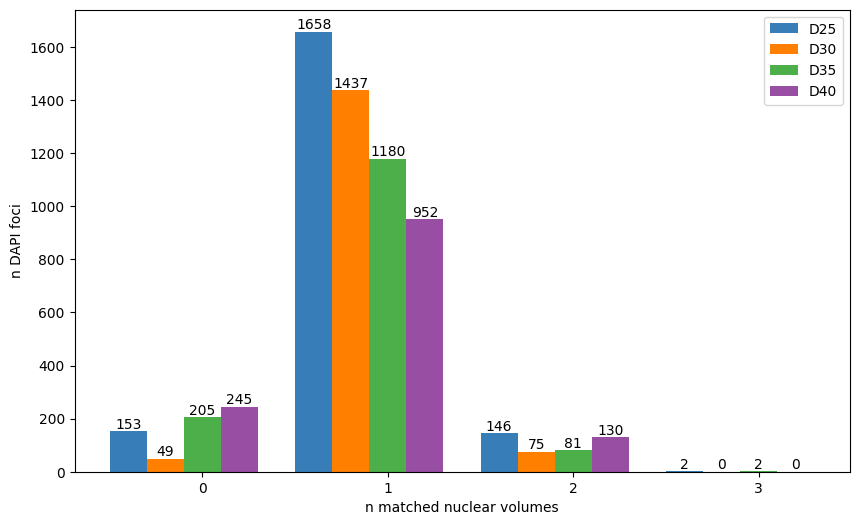

In [ ]:
counters = [Counter(segmentedstack.cc_n_nucleus_matches.values()) for segmentedstack in segmentedstacks]
names = [segmentedstack.name for segmentedstack in segmentedstacks]
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#984ea3"]

# Calculate the union of all keys
all_keys = set().union(*[counter.keys() for counter in counters])

# Width of each bar
width = 0.2

# Calculate the positions for each set of bars
positions = np.arange(len(all_keys))

plt.figure(figsize=(10, 6))

for i, counter in enumerate(counters):
    # Extract keys and corresponding values
    keys = [key for key in all_keys]
    values = [counter.get(key, 0) for key in all_keys]
    plt.bar(positions + (i * width), values, width=width, color=colors[i], label=names[i])

    # Add counts above the bars
    for j, value in enumerate(values):
        plt.text(positions[j] + (i * width), value + 10, str(value), ha='center')

plt.title('')
plt.xlabel('n matched nuclear volumes')
plt.ylabel('n DAPI foci')
plt.xticks(positions + width * len(counters) / 2, all_keys)  # Set x-ticks to center the bars
plt.legend()
plt.show()

## Show distribution nuclei_with_match_type_cc

In [ ]:
#@markdown [data retrieval: df for volumes count per class]
#dev note: combine this with the data retrieval block to minimise redundancy
#create a df for volumes count per class
df = pd.DataFrame(columns=['timepoint',
                           'volumes_with_no_predicted_cc',
                           'volumes_with_all_perfect_cc',
                           'volumes_with_perfect_and_partial_cc',
                           'volumes_with_all_partial_cc'])

for i, segmentedstack in enumerate(segmentedstacks):
    nucleus_ids = segmentedstack.nucleus_ids()
    df.loc[len(df)] = {'timepoint':segmentedstack.name,
                       'volumes_with_no_predicted_cc': len(segmentedstack.nucleus_overview['nuclei_with_no_predicted_cc']),
                        'volumes_with_all_perfect_cc': len(segmentedstack.nucleus_overview['nuclei_with_all_perfect_cc']),
                        'volumes_with_perfect_and_partial_cc':len(segmentedstack.nucleus_overview['nuclei_with_perfect_and_partial_cc']),
                        'volumes_with_all_partial_cc': len(segmentedstack.nucleus_overview['nuclei_with_all_partial_cc'])}

#create a df for sums of the total 3d volumes per timepoint
sum_df = pd.DataFrame({
    'timepoint': df.iloc[:, 0],
    'sum': df.iloc[:, 1:].sum(axis=1)
})

#report
display(df)
display(sum_df)

,timepoint,volumes_with_no_predicted_cc,volumes_with_all_perfect_cc,volumes_with_perfect_and_partial_cc,volumes_with_all_partial_cc
0,D25,222,222,80,34
1,D30,188,300,59,27
2,D35,167,311,59,23
3,D40,138,189,76,28


,timepoint,sum
0,D25,558
1,D30,574
2,D35,560
3,D40,431


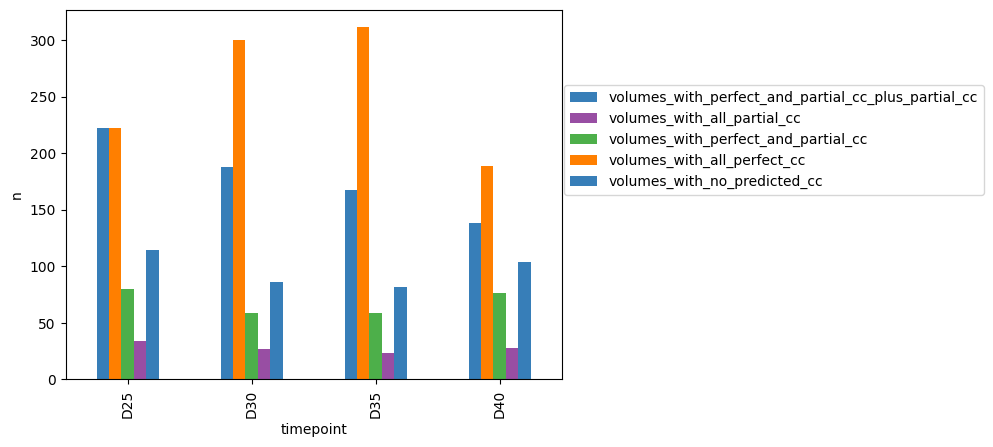

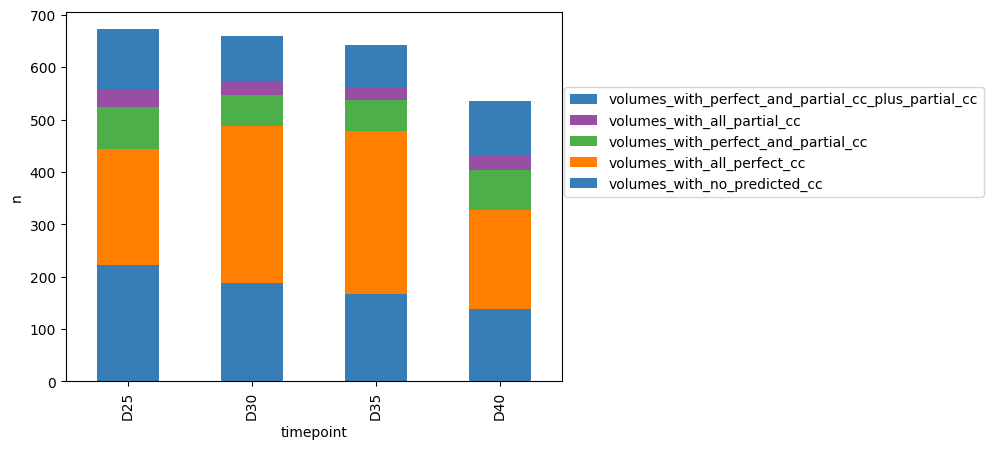

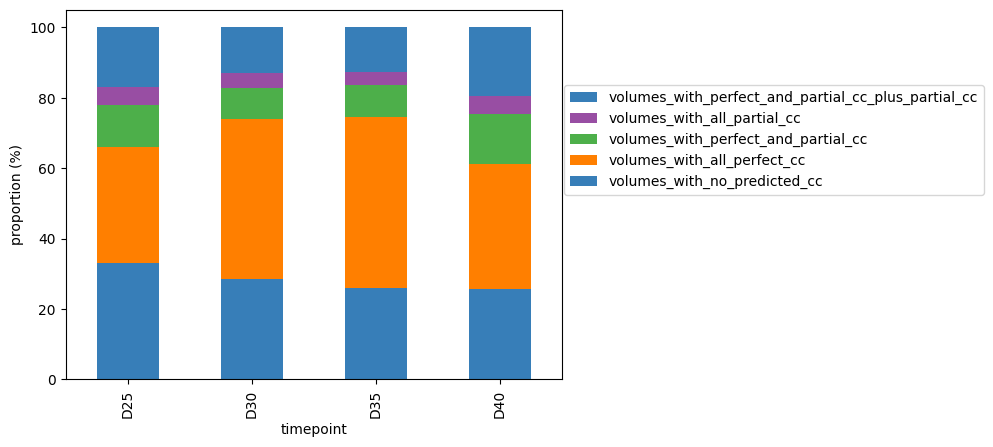

In [ ]:
#@markdown [code; barplots per class]
#plot class as barplots
hatch = ['/', '\\', 'o', '*']
color = ["#377eb8", "#ff7f00", "#4daf4a", "#984ea3"]
#raw counts - not stacked
df.set_index('timepoint').plot(kind='bar', stacked=False, color=color)
plt.xlabel("timepoint")
plt.ylabel("n")

#legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels,loc=(1.005,0.5)) #plt.legend(loc=(-0.05, 1.05), ncol=2)

plt.show()

#raw counts - stacked
df.set_index('timepoint').plot(kind='bar', stacked=True, color=color)
plt.xlabel("timepoint")
plt.ylabel("n")


#legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels,loc=(1.005,0.5)) #plt.legend(loc=(-0.05, 1.05), ncol=2)

plt.show()

#normalised
df_normalised = copy.deepcopy(df)
df_normalised[df_normalised.columns[1:]] = df_normalised[df_normalised.columns[1:]].div(df_normalised[df_normalised.columns[1:]].sum(axis=1), axis=0) * 100
df_normalised.set_index('timepoint').plot(kind='bar', stacked=True, color=color)
plt.xlabel("timepoint")
plt.ylabel("proportion (%)");

#legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels,loc=(1.005,0.5))#plt.legend(loc=(-0.05, 1.05), ncol=2)


plt.show()

In [ ]:
#Retrieving n nuclei that were manually annotated during Cellpose model finetuning
manual_count = {}
for img_path in os.listdir("/content/manual_count"):
    if not img_path.endswith('.tif'):
        continue

    name = img_path.split("_")[0]
    count = len(np.unique(skimage.io.imread(f"/content/manual_count/{img_path}"))) - 1
    manual_count[name] = count

#add D35 which was used in test set
img_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/pipeline_development/golden_standard/filtered_golden_standard_masks.tif"
manual_count["D35"] = len(np.unique(skimage.io.imread(img_path))) - 1

#sort alphabetically
manual_count = dict(sorted(manual_count.items()))
print(manual_count)

{'D25': 278, 'D30': 320, 'D35': 342, 'D40': 269}


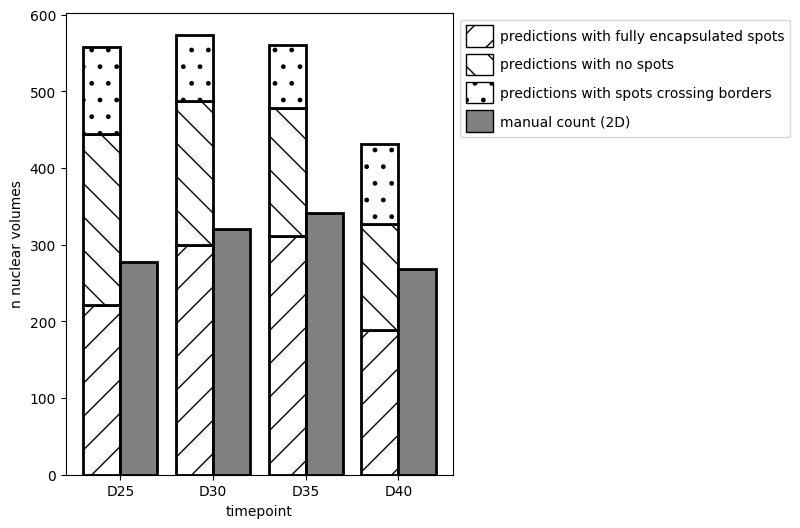

In [ ]:
#@markdown [code: barplot, n predictions vs. manual count]
#data loading
timepoints = manual_count.keys()
df['volumes_with_perfect_and_partial_cc_plus_partial_cc'] = df['volumes_with_perfect_and_partial_cc'] + df['volumes_with_all_partial_cc']

#customisation
figsize=(5,6)
hatch_patterns = ['/', '\\', '.']
square_size = 2 # patch size in legend
labels = ['predictions with fully encapsulated spots', 'predictions with no spots', 'predictions with spots crossing borders']
bar_width = 0.4
linewidth = 2

#data plotting
fig, ax = plt.subplots(figsize=figsize)
x = range(len(df))

# Stacked bar plot for sum with black and white hatching
bottoms = [0] * len(df)
components = ['volumes_with_all_perfect_cc', 'volumes_with_no_predicted_cc', 'volumes_with_perfect_and_partial_cc_plus_partial_cc']

for component, hatch, label in zip(components, hatch_patterns, labels):
    ax.bar(x, df[component], width=bar_width, bottom=bottoms, label=label,
                  hatch=hatch, color='white', edgecolor='black',
                  linewidth=linewidth)
    bottoms = [i + j for i, j in zip(bottoms, df[component])]

# Regular bar plots for other categories
ax.bar([p + bar_width for p in x], manual_count.values(), width=bar_width,
       label='Manual Count', color='gray', edgecolor='black', linewidth=linewidth)

# Set x-axis labels
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df['timepoint'])

# Set axis labels and title
ax.set_xlabel('timepoint')
ax.set_ylabel('n nuclear volumes')

#legend
legend_patches = [Patch(facecolor='white', edgecolor='black',
                        hatch=hatch, label=label) \
                    for hatch, label in zip(hatch_patterns, labels)]
legend_patches.append(Patch(facecolor='gray', edgecolor='black', label='manual count (2D)'))
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1,1),
          handlelength=square_size, handleheight=square_size,
          handletextpad=0.5, ncols=1)


plt.show();

## [Optional] Export nuclear predictions per class as separate matrices
Classes:
1. nuclear segmentations with no spots
2. nuclear segmentations with all encapsulated spots
3. nuclear segmentations with some spilled, and some partial spots
4. nuclear segmentations with all partial spots.


.TIF files will be generated in the session directory as `<segmentedstack.name>_<nucleus_class>.tif`

In [ ]:
#loop through each stored stack
nuclei_class_names = {
    'nuclei_with_no_predicted_cc': 'nuclei_no_spots',
    'nuclei_with_all_perfect_cc': 'nuclei_all_encapsulated_spots',
    'nuclei_with_perfect_and_partial_cc': 'nuclei_some_partial_spots',
    'nuclei_with_all_partial_cc': 'nuclei_all_partial_spots'
}

for segmentedstack in segmentedstacks: # [segmentedstacks[0]]:
    for nucleus_class, nucleus_ids in segmentedstack.nucleus_overview.items():
        print(f"{datetime.now()}\tProcessing {segmentedstack.name} - {nucleus_class}")
        #retain nuclei from the class
        class_matrix = copy.deepcopy(segmentedstack.nucleus_matrix)
        class_matrix = np.where(np.isin(class_matrix, nucleus_ids), class_matrix, 0)

        #write to file
        tifffile.imwrite(
            f'{segmentedstack.name}_{nuclei_class_names[nucleus_class]}.tif',
            class_matrix, bigtiff=True)

2024-07-05 12:05:08.806049	Processing D25 - nuclei_with_no_predicted_cc
2024-07-05 12:05:09.847750	Processing D25 - nuclei_with_all_perfect_cc
2024-07-05 12:05:11.004132	Processing D25 - nuclei_with_perfect_and_partial_cc
2024-07-05 12:05:15.341173	Processing D25 - nuclei_with_all_partial_cc
2024-07-05 12:05:16.590753	Processing D30 - nuclei_with_no_predicted_cc
2024-07-05 12:05:20.801267	Processing D30 - nuclei_with_all_perfect_cc
2024-07-05 12:05:22.038140	Processing D30 - nuclei_with_perfect_and_partial_cc
2024-07-05 12:05:25.786085	Processing D30 - nuclei_with_all_partial_cc
2024-07-05 12:05:31.729665	Processing D35 - nuclei_with_no_predicted_cc
2024-07-05 12:05:41.655127	Processing D35 - nuclei_with_all_perfect_cc
2024-07-05 12:05:45.749107	Processing D35 - nuclei_with_perfect_and_partial_cc
2024-07-05 12:05:49.869940	Processing D35 - nuclei_with_all_partial_cc
2024-07-05 12:05:54.546422	Processing D40 - nuclei_with_no_predicted_cc
2024-07-05 12:05:56.214556	Processing D40 - nucle

# END OF OFFICIAL CODE

Below, you can find the code for the quantitative analyses of chromocentres. This code was not used for the final results in the report as the spot detection should be refined for accurate quantification.

Once 3D spot detection is improved, this code can be used as a foundation for downstream analyses.

# Filter
at the moment, nucleusobject.n_chromocenters returns the number of all perfect ccs per nucleus.

for future work, partial CCs could be assigned to nuclei based on percentage for example.

In [ ]:
#@markdown Filtering nuclei based on estimated CC quality
incl_nuclei_with_no_predicted_cc = False #@param {type:"boolean"}
incl_nuclei_with_all_perfect_cc = True  #@param {type:"boolean"}
incl_nuclei_with_perfect_and_partial_cc = False #@param {type:"boolean"}
incl_nuclei_with_all_partial_cc = False #@param {type:"boolean"}

#data retrieval
analysed_nuclei_dict = {} #init

#loop through each stored stack
for segmentedstack in segmentedstacks: # [segmentedstacks[0]]:
    analysed_nucleus_ids = []

    if incl_nuclei_with_no_predicted_cc:
        analysed_nucleus_ids += segmentedstack.nucleus_overview['nuclei_with_no_predicted_cc']

    if incl_nuclei_with_all_perfect_cc:
        analysed_nucleus_ids += segmentedstack.nucleus_overview['nuclei_with_all_perfect_cc']

    if incl_nuclei_with_perfect_and_partial_cc:
        analysed_nucleus_ids += segmentedstack.nucleus_overview['nuclei_with_perfect_and_partial_cc']

    if incl_nuclei_with_all_partial_cc:
        analysed_nucleus_ids += segmentedstack.nucleus_overview['nuclei_with_all_partial_cc']

    print(f'adding {analysed_nucleus_ids[:4]}... to {segmentedstack.name} in analysed_nuclei_dict')
    analysed_nuclei_dict[segmentedstack.name] = analysed_nucleus_ids

#save settings
analysis_settings = {"incl_nuclei_with_no_predicted_cc" : incl_nuclei_with_no_predicted_cc,
                     "incl_nuclei_with_all_perfect_cc" : incl_nuclei_with_all_perfect_cc,
                     "incl_nuclei_with_perfect_and_partial_cc" : incl_nuclei_with_perfect_and_partial_cc,
                     "incl_nuclei_with_all_partial_cc" : incl_nuclei_with_all_partial_cc}
print("--SETTINGS--")
for k,v in analysis_settings.items():
    print(f"{k}: {v}")

print("\n--N NUCLEI ANALYSED--")
for name, nuclei_ids in analysed_nuclei_dict.items():
    print(f"{name}\t{len(nuclei_ids)}")

adding [3, 4, 5, 6]... to D25 in analysed_nuclei_dict
adding [2, 3, 5, 6]... to D30 in analysed_nuclei_dict
adding [3, 4, 6, 7]... to D35 in analysed_nuclei_dict
adding [3, 5, 6, 7]... to D40 in analysed_nuclei_dict
--SETTINGS--
incl_nuclei_with_no_predicted_cc: False
incl_nuclei_with_all_perfect_cc: True
incl_nuclei_with_perfect_and_partial_cc: False
incl_nuclei_with_all_partial_cc: False

--N NUCLEI ANALYSED--
D25	222
D30	300
D35	311
D40	189


In [ ]:
save=True #@param {type:"boolean"}
output_file_name = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/multi_otsu/analysis_settings.json"#@param {type:"string"}
if save:
    with open(output_file_name, 'w') as file_obj:
        json.dump(analysis_settings, file_obj)

##Show distribution of n CC per nucleus per timepoint

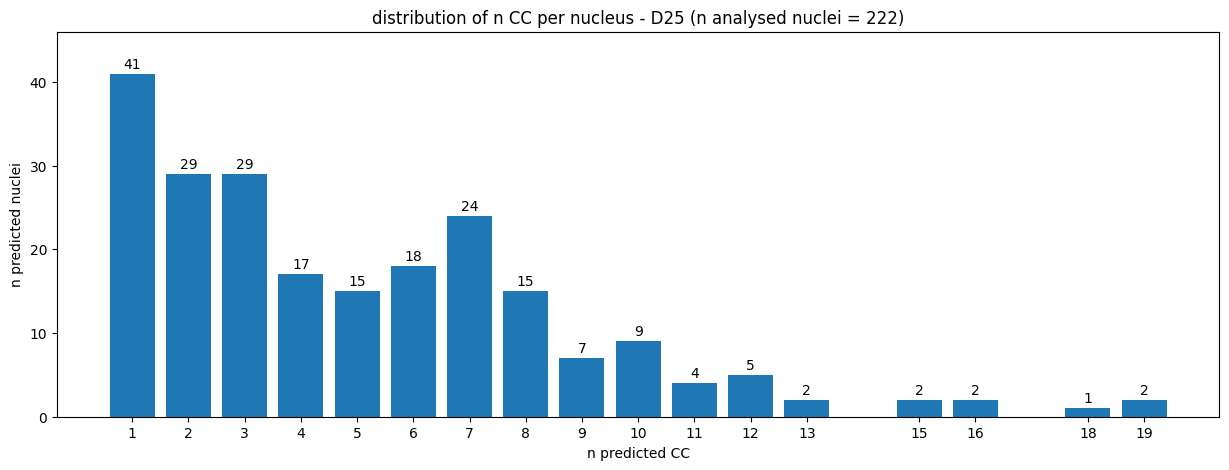

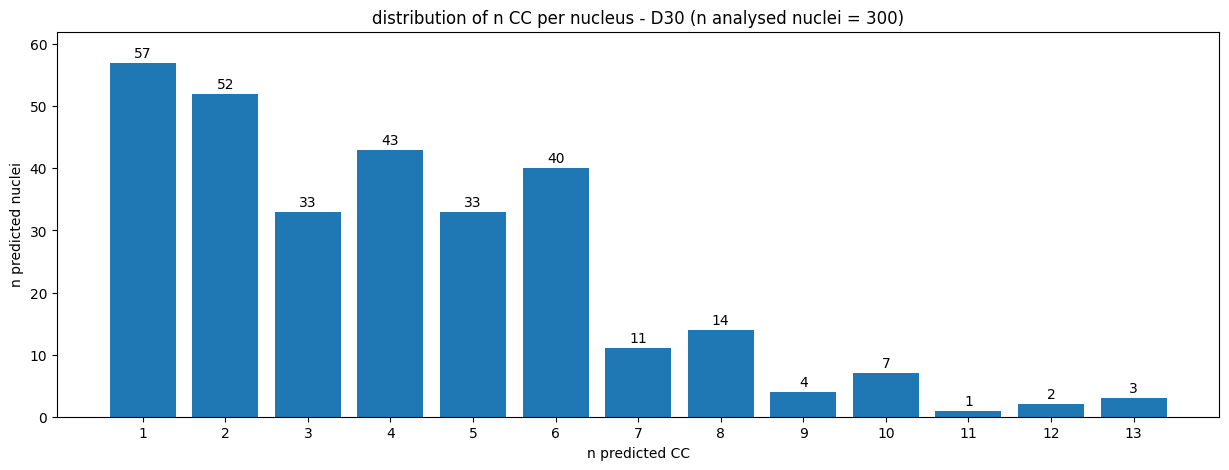

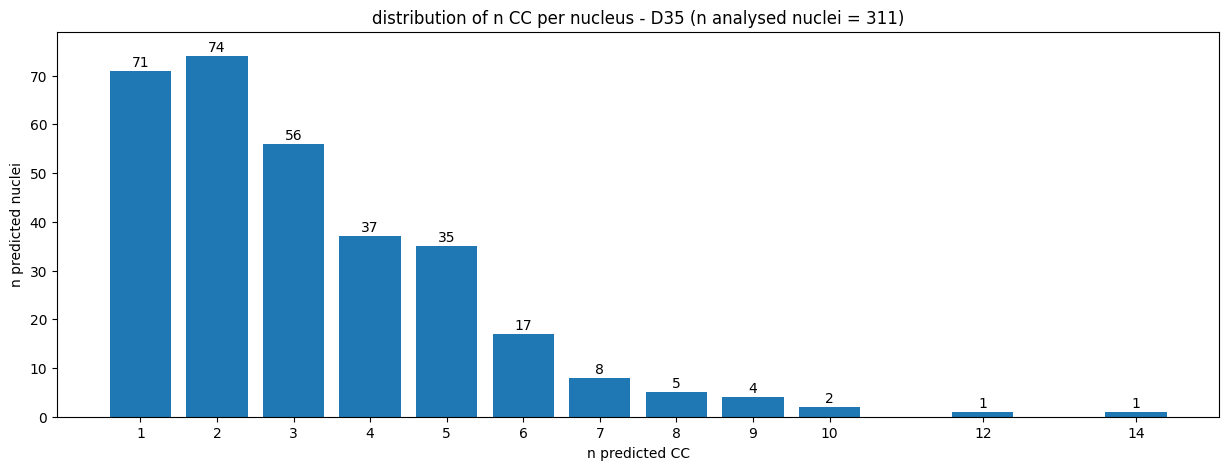

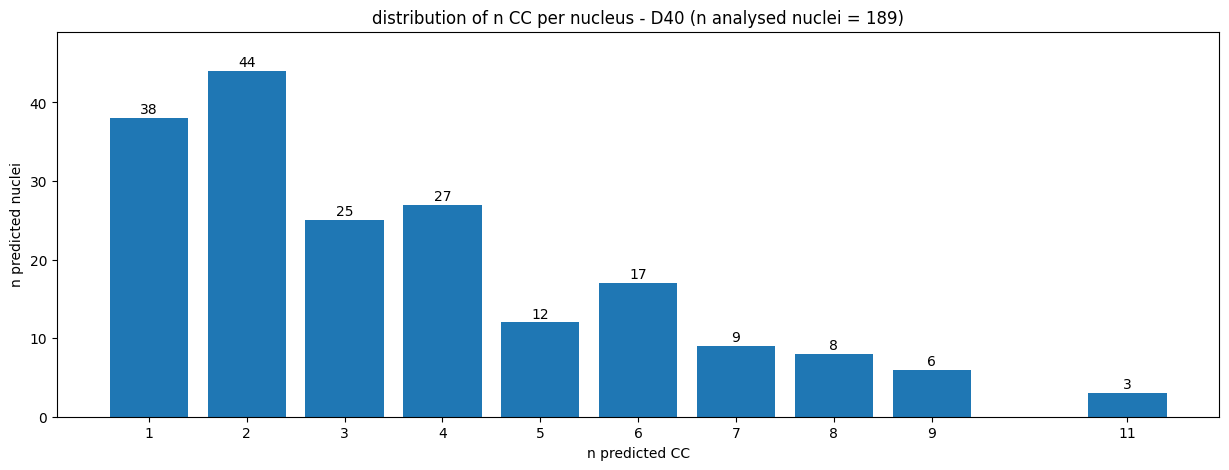

In [ ]:
#visualisation options
margin = 0.003 #@param
y_increase = 5  #@param

#plot for each stored segmentedstack
for segmentedstack in segmentedstacks:
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    n_cc_distribution = [segmentedstack.nucleus_dict[nucleus_id].n_chromocenters for nucleus_id in analysed_nucleus_ids]
    value_counts = Counter(n_cc_distribution) #{n CCs : count}
    value_counts = dict(sorted(value_counts.items())) #sorted by n CCs, ascending

    #plot (x: n CCs, y: count)
    x = list(value_counts.keys())
    y = list(value_counts.values())

    plt.figure(figsize=(15,5))
    plt.bar(x, y)
    plt.ylim(0, max(y) + y_increase)  # adjust y-axis limits so that text fits nicely
    plt.xticks(x)
    plt.xlabel('n predicted CC')
    plt.ylabel('n predicted nuclei')
    plt.title(f'distribution of n CC per nucleus - {segmentedstack.name} (n analysed nuclei = {len(analysed_nucleus_ids)})')

    #plotting counts on top of bar
    total = sum(y)
    for i, x_val in enumerate(x): #plotting percentage on top of bar
        #plt.text(x_val, y[i] + margin*total, f'{y[i]}\n({y[i]/total:.2%})', ha='center') #incl percentage
        plt.text(x_val, y[i] + margin*total, f'{y[i]}', ha='center')

    plt.show();

## as a stacked barplot



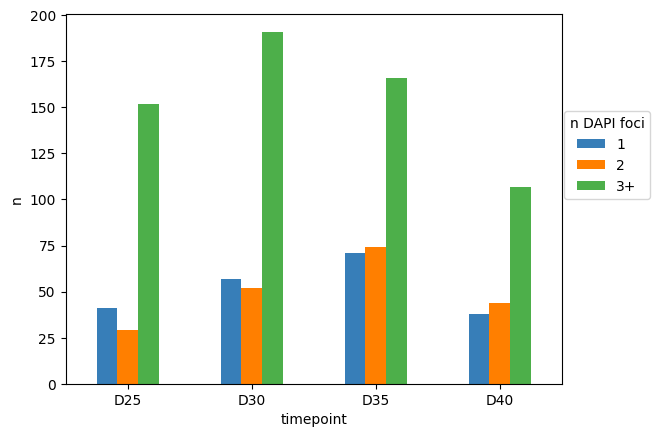

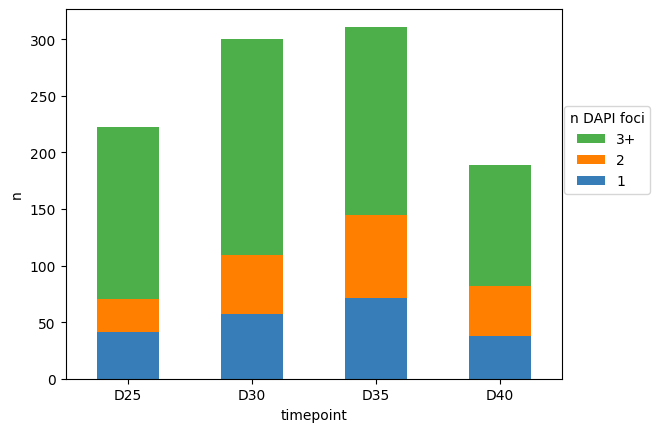

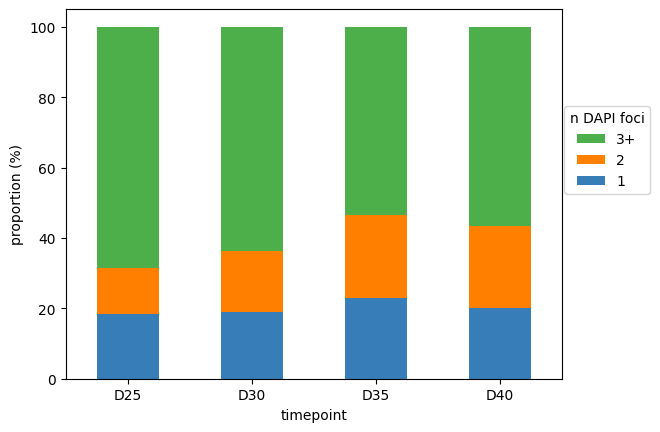

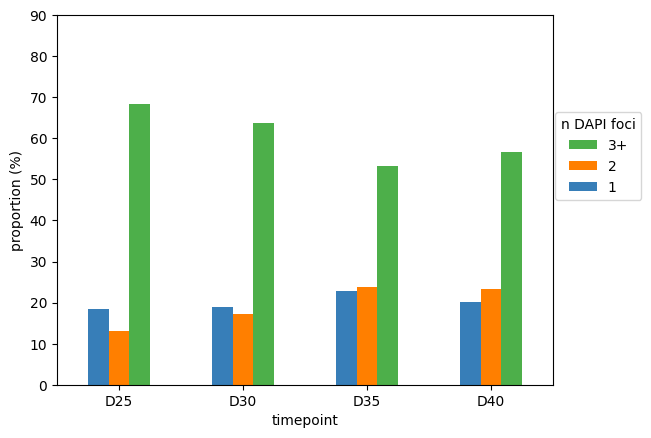

In [ ]:
#@markdown **Specify the cc classes**
n_cc_classes = [1,2] #@param
color = ["#377eb8", "#ff7f00", "#4daf4a"] #, "#984ea3", '#000000'] # '#404040', '#808080', '#CCCCCC'] #@param

#Create a DF for plotting
df = pd.DataFrame(columns=['timepoint']+n_cc_classes+[f"{n_cc_classes[-1]+1}+"])

for segmentedstack in segmentedstacks:
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]
    df.loc[len(df)] = {"timepoint":segmentedstack.name}

    #classify nuclei based on number of chromocentres
    n_nuclei_with_n_cc = []
    for n_cc_count in n_cc_classes:
        n_nuclei_with_n_cc.append(len([nucleus_id for nucleus_id in analysed_nucleus_ids if segmentedstack.nucleus_dict[nucleus_id].n_chromocenters == n_cc_count]))
    n_nuclei_with_n_cc.append(len([nucleus_id for nucleus_id in analysed_nucleus_ids if segmentedstack.nucleus_dict[nucleus_id].n_chromocenters > n_cc_classes[-1]]))

    #add to the DF
    df.loc[df['timepoint'] == segmentedstack.name, n_cc_classes+[f"{n_cc_classes[-1]+1}+"]] = n_nuclei_with_n_cc

#raw counts - not stacked
df.set_index('timepoint').plot(kind='bar', stacked=False, color=color) #dev: add a nice palette here!!
plt.xlabel("timepoint")
plt.xticks(rotation=0)
plt.ylabel("n")

#legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="n DAPI foci",loc=(1.005,0.5)) #plt.legend(title="n chromocentres", loc=(0.2, 1.01), ncol=len(n_cc_classes)+1)
plt.show()

#raw counts - stacked
df.set_index('timepoint').plot(kind='bar', stacked=True, color=color) #dev: add a nice palette here!!
plt.xlabel("timepoint")
plt.xticks(rotation=0)
plt.ylabel("n")

#legend - in same order as stack, top to bottom
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels, title="n DAPI foci", loc=(1.005,0.5)) #plt.legend(title="n chromocentres", loc=(0.2, 1.01), ncol=len(n_cc_classes)+1)

plt.show()

#normalised
df[df.columns[1:]] = df[df.columns[1:]].div(df[df.columns[1:]].sum(axis=1), axis=0) * 100
df.set_index('timepoint').plot(kind='bar', stacked=True, color=color) #dev: add a nice palette here!!
plt.xlabel("timepoint")
plt.xticks(rotation=0)
plt.ylabel("proportion (%)")

#legend - in same order as stack, top to bottom
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels, title="n DAPI foci", loc=(1.005,0.5)) #plt.legend(title="n chromocentres", loc=(0.2, 1.01), ncol=len(n_cc_classes)+1)
plt.show();

#normalised - not stacked
#df[df.columns[1:]] = df[df.columns[1:]].div(df[df.columns[1:]].sum(axis=1), axis=0) * 100
df.set_index('timepoint').plot(kind='bar', stacked=False, color=color) #dev: add a nice palette here!!
plt.xlabel("timepoint")
plt.xticks(rotation=0)
plt.ylabel("proportion (%)")
plt.yticks(ticks=np.arange(0, 100, 10))

#legend - in same order as stack, top to bottom
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels, title="n DAPI foci", loc=(1.005,0.5)) #plt.legend(title="n chromocentres", loc=(0.2, 1.01), ncol=len(n_cc_classes)+1)
plt.show();

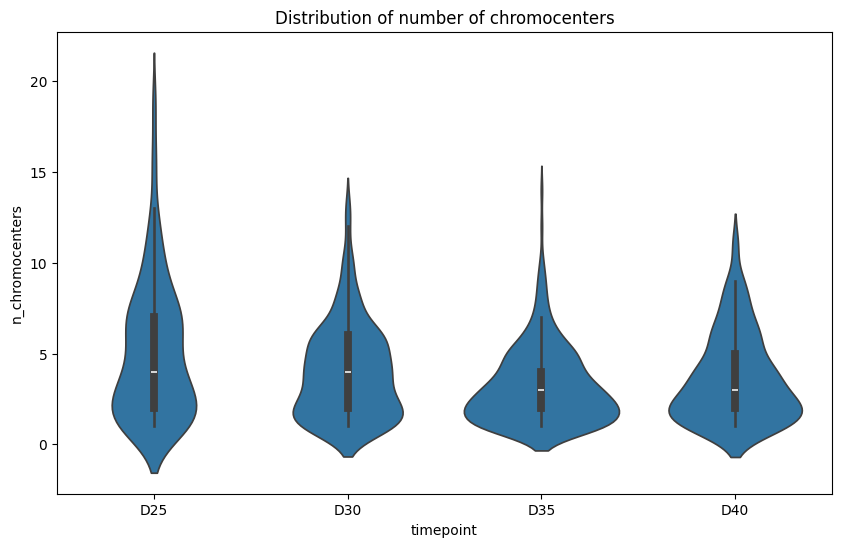

In [ ]:
#Create a DF for plotting
df = pd.DataFrame(columns=['timepoint', 'n_chromocenters'])

for segmentedstack in segmentedstacks:
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    #store each n_chromocenter for the nuclei on separate rows
    for nucleus_id in analysed_nucleus_ids:
        df.loc[len(df)] = {"timepoint":segmentedstack.name,
                           'n_chromocenters':segmentedstack.nucleus_dict[nucleus_id].n_chromocenters}

# visualisation: x = timepoint, y = distribution n_chromocenters
plt.figure(figsize=(10, 6))
sns.violinplot(x='timepoint', y='n_chromocenters', data=df, inner='box')
#sns.stripplot(x='timepoint', y='n_chromocenters', data=df, jitter=True, color='black', alpha=0.2)
plt.title('Distribution of number of chromocenters')
plt.show()

In [ ]:
# changes in volume of chromocenters depending on how many chromocenters there are (i.e. n chromo 1 >> n chromo 5) - chromo merging

#df: timepoint _ nucleus id _ n chromo _ chromo id _ volume

print(f"{datetime.now()}\tStarted processing")

df = pd.DataFrame(columns=['timepoint', 'nucleus_id', 'n_chromocenters', 'chromocenter_id', 'chromocenter_volume'])

for segmentedstack in segmentedstacks:
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    for i, nucleus_id in enumerate(analysed_nucleus_ids, 1):

        n_chromocenters = segmentedstack.nucleus_dict[nucleus_id].n_chromocenters

        #get volume of each chromocenter (number of voxels)
        for chromocenter_id in segmentedstack.nucleus_dict[nucleus_id].perfect_cc_ids:
            chromocenter_volume = np.sum(segmentedstack.chromocenter_matrix == chromocenter_id)

            #add to the dataframe
            df.loc[len(df)] = {"timepoint":segmentedstack.name,
                               'nucleus_id':nucleus_id,
                               'n_chromocenters':n_chromocenters,
                               'chromocenter_id':chromocenter_id,
                               'chromocenter_volume':chromocenter_volume}

        print(f'\r{datetime.now()}\tProcessing {segmentedstack.name} - {i/len(analysed_nucleus_ids)*100}%', end='')
    print()

# add scale to the df
def calculate_scaled_volume(row):
    if row['timepoint'] in ['D25', 'D30']:
        volume_scale = 0.11 * 0.11 * 0.05
    elif row['timepoint'] in ['D35', 'D40']:
        volume_scale = 0.17 * 0.17 * 0.05

    return row['chromocenter_volume'] * volume_scale

# Apply the function to create the new column 'scaled_volume'
df['scaled_chromocenter_volume'] = df.apply(calculate_scaled_volume, axis=1)

display(df)

#report and save
df.to_csv('./chromocentre_volumes.csv', index=False)
!cp /content/chromocentre_volumes.csv /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset

2024-05-18 15:19:35.721608	Started processing
2024-05-18 15:22:18.453796	Processing D25 - 100.0%
2024-05-18 15:25:23.519138	Processing D30 - 100.0%
2024-05-18 15:28:19.671997	Processing D35 - 100.0%
2024-05-18 15:30:46.077462	Processing D40 - 100.0%


,timepoint,nucleus_id,n_chromocenters,chromocenter_id,chromocenter_volume
0,D25,2,2,1012,1509
1,D25,2,2,22267,806
2,D25,4,1,581,871
3,D25,5,8,582,84
4,D25,5,8,714,742
...,...,...,...,...,...
2908,D40,528,1,9962,1712
2909,D40,538,2,16151,147
2910,D40,538,2,17085,341
2911,D40,561,1,21945,62


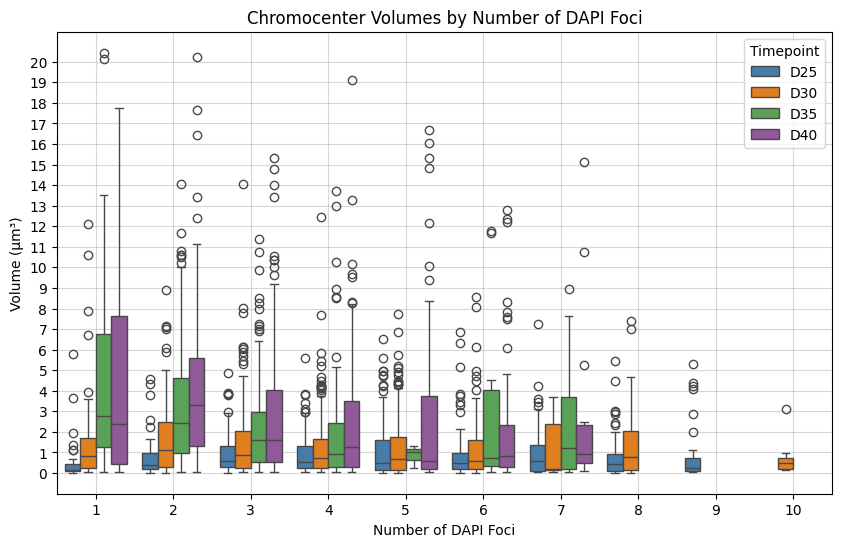

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='n_chromocenters', y='scaled_chromocenter_volume', hue='timepoint', data=df, palette=color)

#axis clarity
plt.yticks(range(int(df['scaled_chromocenter_volume'].min()), int(df['scaled_chromocenter_volume'].max())+1))
plt.grid(True, alpha=0.5)

# Add titles and labels
plt.title('Chromocenter Volumes by Number of DAPI Foci')
plt.xlabel('Number of DAPI Foci')
plt.ylabel('Volume (µm³)')
plt.legend(title='Timepoint')

# Show the plot
plt.show()


In [ ]:
#@markdown welchs_results_df:

from itertools import combinations
from scipy.stats import ttest_ind

# Define alpha levels for different symbols
alpha_levels = [(0.001, '***'), (0.01, '**'), (0.05, '*')] #in ascending order of significance

# Get all unique combinations of timepoints
all_timepoints = sorted(df['timepoint'].unique())
timepoint_combinations = list(combinations(all_timepoints, 2))

# Initialize lists to store results
results = []

# Perform Welch's t-test for all possible pairwise comparisons between timepoints within each n_chromocenter class
for n_chromocenter, data in df.groupby('n_chromocenters'):
    for timepoint1, timepoint2 in timepoint_combinations:
        group1 = data[data['timepoint'] == timepoint1]['scaled_chromocenter_volume']
        group2 = data[data['timepoint'] == timepoint2]['scaled_chromocenter_volume']

        # Perform Welch's t-test
        ttest_result = ttest_ind(group1, group2, equal_var=False)

        # Check significance
        significance = ''
        for alpha_level, symbol in alpha_levels:
            if float(ttest_result.pvalue) < alpha_level:
                significance = symbol
                break

        # Append results to list
        results.append({
            'n_chromocenter': n_chromocenter,
            'timepoint1': timepoint1,
            'timepoint2': timepoint2,
            'p_value': ttest_result.pvalue,
            'significance': significance
        })

# Create DataFrame from results
welchs_results_df = pd.DataFrame(results)

display(welchs_results_df)

welchs_results_df.to_csv('welchs_t_test_alpha0.05.csv')

In [ ]:
#@markdown mannwhitneyu:  n_chromocenter	timepoint1	timepoint2	p_value	significance
#0	1	D25	D30	0.000026	***

from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

# Define alpha levels for different symbols
alpha_levels = [(0.001, '***'), (0.01, '**'), (0.05, '*')] #in ascending order of significance

# Get all unique combinations of timepoints
all_timepoints = sorted(df['timepoint'].unique())
timepoint_combinations = list(combinations(all_timepoints, 2))

# Initialize lists to store results
results_mannwhitneyu = []

# Perform Mann-Whitney U test for all possible pairwise comparisons between timepoints within each n_chromocenter class
for n_chromocenter, data in df.groupby('n_chromocenters'):
    for timepoint1, timepoint2 in timepoint_combinations:
        group1 = data[data['timepoint'] == timepoint1]['scaled_chromocenter_volume']
        group2 = data[data['timepoint'] == timepoint2]['scaled_chromocenter_volume']

        # Perform Mann-Whitney U test, for when two timepoint groups are present
        try:
            mwu_result = mannwhitneyu(group1, group2, alternative='two-sided')

            p_value = mwu_result.pvalue
            # Check significance
            significance = ''
            for alpha_level, symbol in alpha_levels:
                if p_value< alpha_level:
                    significance = symbol
                    break

        except ValueError:
            p_value = ''
            significance = ''

        # Append results to list
        results_mannwhitneyu.append({
            'n_chromocenter': n_chromocenter,
            'timepoint1': timepoint1,
            'timepoint2': timepoint2,
            'p_value': p_value,
            'significance': significance
        })

# Create DataFrame from results
mwu_results_df = pd.DataFrame(results_mannwhitneyu)

display(mwu_results_df)

mwu_results_df.to_csv('mann_whitney_u_test_alpha0.05.csv')


,n_chromocenter,timepoint1,timepoint2,p_value,significance
0,1,D25,D30,0.000026,***
1,1,D25,D35,0.0,***
2,1,D25,D40,0.0,***
3,1,D30,D35,0.0,***
4,1,D30,D40,0.000815,***
5,1,D35,D40,0.486087,
6,2,D25,D30,0.000254,***
7,2,D25,D35,0.0,***
8,2,D25,D40,0.0,***
9,2,D30,D35,0.0,***


In [ ]:
#@markdown welch vs mwu
df = pd.DataFrame({"n_chromocenter":mwu_results_df['n_chromocenter'],
                   "timepoint1": mwu_results_df["timepoint1"],
                   "timepoint2": mwu_results_df["timepoint2"],
                    "mwu":mwu_results_df['significance'],
                   "welchs":welchs_results_df['significance']})
display(df)

# CC metrics from paper
NCC: the number of unique values in chromocenter_labels (number of CC's)

relative CC area fraction (RAF): the min, max, and mean area of each CC/nucleus area

Heterochromatin fraction (HF): sum of all chromocenters’ areas/nucleus area

In [ ]:
verbose=False
print(f"{datetime.now()}\tStarted processing")

df = pd.DataFrame(columns=['timepoint', 'nucleus_id', 'nuclear_volume', 'n_chromocenters', 'RVF_min', 'RVF_mean', 'RVF_max', 'HF'])

for segmentedstack in segmentedstacks:
    #retrieve analysed ids
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    for i, nucleus_id in enumerate(analysed_nucleus_ids, 1):
        print(f'\r{datetime.now()}\tProcessing {segmentedstack.name} - {i/len(analysed_nucleus_ids)*100}%', end='')

        nuclear_volume = np.sum(segmentedstack.nucleus_matrix == nucleus_id)
        if verbose: print("nuclear_volume ", nuclear_volume)

        n_chromocenters = segmentedstack.nucleus_dict[nucleus_id].n_chromocenters
        if verbose: print('n_chromocenters', n_chromocenters)

        cc_volumes = []
        #get volume of each chromocenter (number of voxels)
        for chromocenter_id in segmentedstack.nucleus_dict[nucleus_id].perfect_cc_ids:
            cc_volume = np.sum(segmentedstack.chromocenter_matrix == chromocenter_id)
            if verbose: print("cc_volume ", cc_volume)
            #normalise to nucleus volume
            cc_volume = cc_volume / nuclear_volume
            cc_volumes.append(cc_volume)

        #calculate relative volume fractions
        RVF_min = min(cc_volumes)
        RVF_max = max(cc_volumes)
        RVF_mean = sum(cc_volumes) / len(cc_volumes)
        if verbose: print(RVF_min, RVF_max, RVF_mean)

        #calculate heterochromatin fraction
        HF = 0
        HF = sum(cc_volumes)

        #add to the dataframe
        df.loc[len(df)] = {"timepoint":segmentedstack.name,
                            'nucleus_id':nucleus_id,
                           'nuclear_volume':nuclear_volume,
                            'n_chromocenters':n_chromocenters,
                           'RVF_min':RVF_min,
                           'RVF_mean':RVF_mean,
                           'RVF_max':RVF_max,
                           'HF':HF}
    #    if i==10: break #10 nuclei
    #break #single stack

display(df)

#report and save
df.to_csv('./RVF_HF_stats.csv', index=False)
!cp /content/RVF_HF_stats.csv /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset

2024-05-20 06:54:18.671454	Started processing
2024-05-20 07:07:58.348687	Processing D40 - 100.0%

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,RVF_min,RVF_mean,RVF_max,HF
0,D25,2,64337,2,0.012528,0.017991,0.023455,0.035982
1,D25,4,58079,1,0.014997,0.014997,0.014997,0.014997
2,D25,5,67305,8,0.001040,0.010293,0.024604,0.082342
3,D25,6,57671,4,0.001144,0.015055,0.050684,0.060221
4,D25,7,124805,4,0.000617,0.006550,0.012876,0.026201
...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,0.026275,0.026275,0.026275,0.026275
1078,D40,528,9270,1,0.184682,0.184682,0.184682,0.184682
1079,D40,538,10224,2,0.014378,0.023865,0.033353,0.047731
1080,D40,561,11731,1,0.005285,0.005285,0.005285,0.005285


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/RVF_HF_stats.csv")
df['scaled_nuclear_volume']= None
for idx, row in df.iterrows():

    if row['timepoint'] in ['D25', 'D30']:
        df.at[idx, 'scaled_nuclear_volume'] = row['nuclear_volume'] *0.11*0.11*0.05
    if row['timepoint'] in ['D35', 'D40']:
        df.at[idx, 'scaled_nuclear_volume'] = row['nuclear_volume'] *0.17*0.17*0.05

In [ ]:
df

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,RVF_min,RVF_mean,RVF_max,HF,scaled_nuclear_volume
0,D25,2,64337,2,0.012528,0.017991,0.023455,0.035982,38.923885
1,D25,4,58079,1,0.014997,0.014997,0.014997,0.014997,35.137795
2,D25,5,67305,8,0.001040,0.010293,0.024604,0.082342,40.719525
3,D25,6,57671,4,0.001144,0.015055,0.050684,0.060221,34.890955
4,D25,7,124805,4,0.000617,0.006550,0.012876,0.026201,75.507025
...,...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,0.026275,0.026275,0.026275,0.026275,10.229155
1078,D40,528,9270,1,0.184682,0.184682,0.184682,0.184682,13.39515
1079,D40,538,10224,2,0.014378,0.023865,0.033353,0.047731,14.77368
1080,D40,561,11731,1,0.005285,0.005285,0.005285,0.005285,16.951295


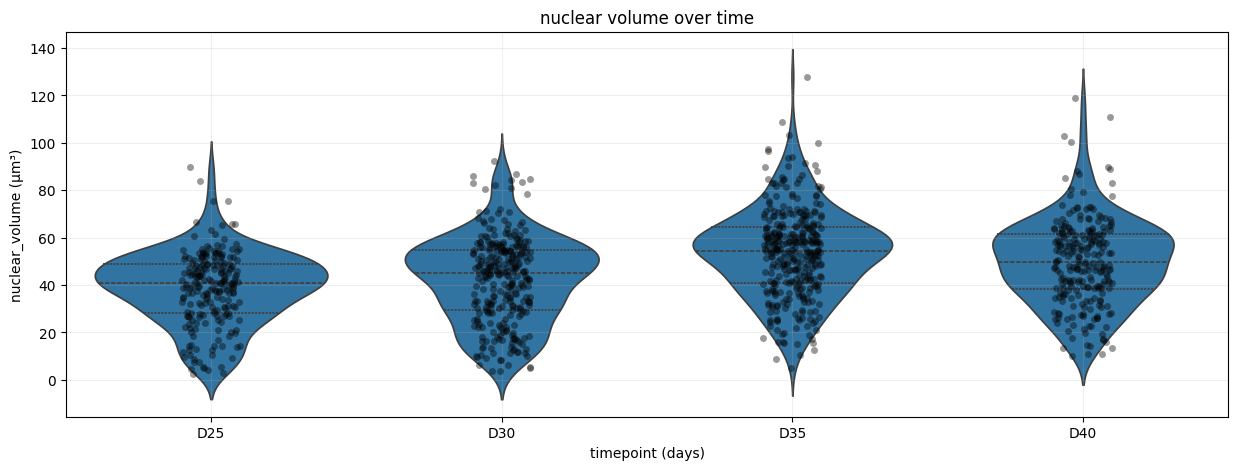

In [ ]:
#@markdown relative cc volume fraction by n foci
plt.figure(figsize=(15,5))

sns.violinplot(x='timepoint', y='scaled_nuclear_volume', data=df, inner='quart')#, palette=color)
sns.stripplot(x='timepoint', y='scaled_nuclear_volume', data=df, color='black', alpha=0.4)#, palette=color)

#axis clarity
#plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True, alpha=0.2)

# Add titles and labels
plt.title('nuclear volume over time')
plt.xlabel('timepoint (days)')
plt.ylabel('nuclear_volume (µm³)')

# Show the plot
plt.show();

<ipython-input-23-3d1e594d0e8c>:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(x='n_chromocenters', y='RVF_mean', hue='timepoint', data=df, palette=color)


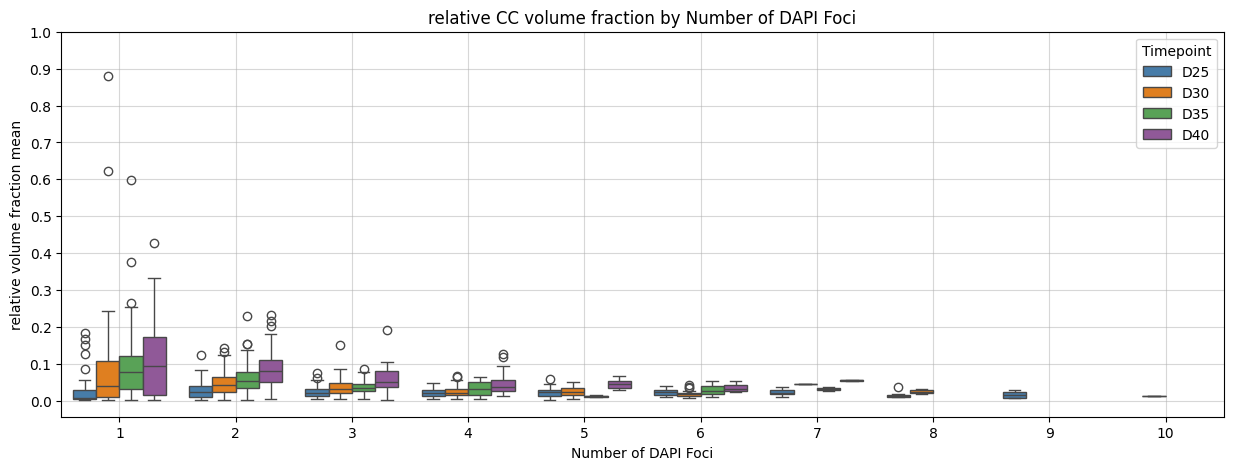

In [ ]:
#@markdown relative cc volume fraction by n foci
plt.figure(figsize=(15,5))

sns.boxplot(x='n_chromocenters', y='RVF_mean', hue='timepoint', data=df, palette=color)
#sns.violinplot(x='n_chromocenters', y='RVF_mean', hue='timepoint', inner='quart', data=df, palette=color)

#axis clarity
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True, alpha=0.5)

# Add titles and labels
plt.title('relative CC volume fraction by Number of DAPI Foci')
plt.xlabel('Number of DAPI Foci')
plt.ylabel('relative volume fraction mean')
plt.legend(title='Timepoint')

# Show the plot
plt.show()


<ipython-input-27-d6df393934ae>:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(x='n_chromocenters', y='HF', hue='timepoint', data=df, palette=color)


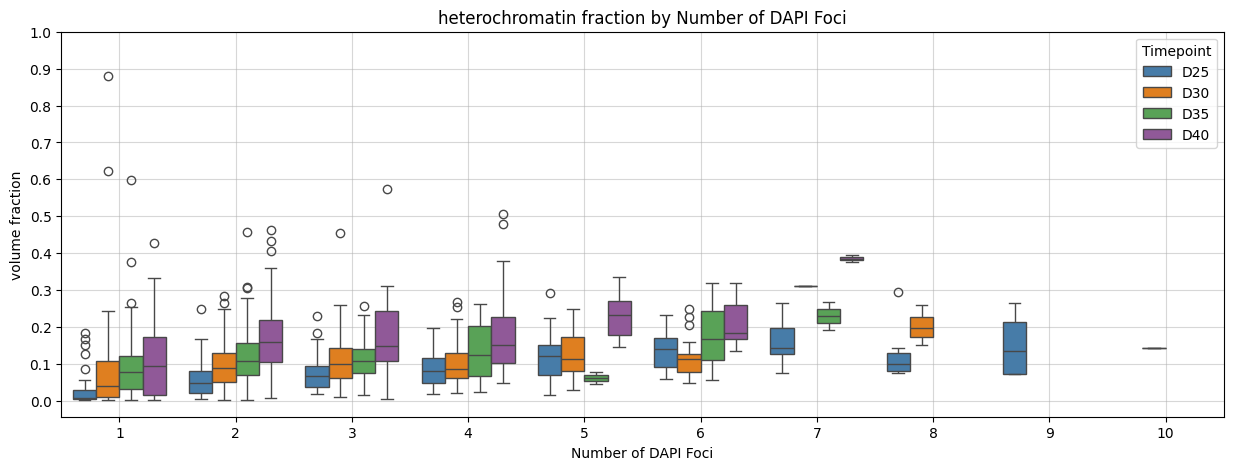

In [ ]:
#@markdown relative cc volume fraction by n foci
plt.figure(figsize=(15,5))

sns.boxplot(x='n_chromocenters', y='HF', hue='timepoint', data=df, palette=color)
#sns.violinplot(x='n_chromocenters', y='RVF_mean', hue='timepoint', inner='quart', data=df, palette=color)

#axis clarity
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True, alpha=0.5)

# Add titles and labels
plt.title('heterochromatin fraction by Number of DAPI Foci')
plt.xlabel('Number of DAPI Foci')
plt.ylabel('volume fraction')
plt.legend(title='Timepoint')

# Show the plot
plt.show()


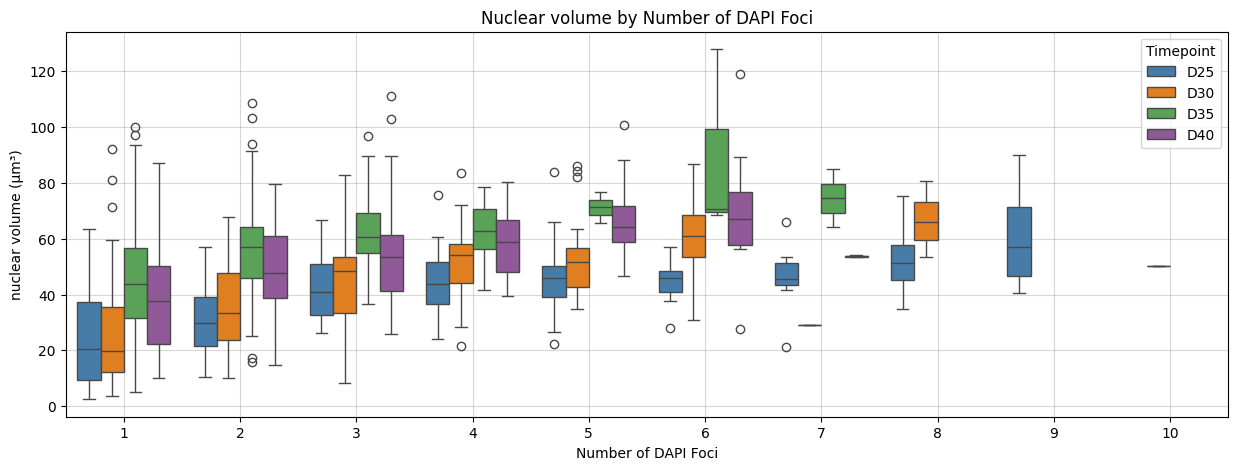

In [ ]:
#@markdown nuclear volume per nCC per timepoint
# add scale to the df
def calculate_scaled_volume(row):
    if row['timepoint'] in ['D25', 'D30']:
        volume_scale = 0.11 * 0.11 * 0.05
    elif row['timepoint'] in ['D35', 'D40']:
        volume_scale = 0.17 * 0.17 * 0.05

    return row['nuclear_volume'] * volume_scale

# Apply the function to create the new column 'scaled_volume'
df['nuclear_volume_scaled'] = df.apply(calculate_scaled_volume, axis=1)
plt.figure(figsize=(15,5))

sns.boxplot(x='n_chromocenters', y='nuclear_volume_scaled', hue='timepoint', data=df, palette=color)
#sns.violinplot(x='n_chromocenters', y='RVF_mean', hue='timepoint', inner='quart', data=df, palette=color)

#axis clarity
#plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True, alpha=0.5)

# Add titles and labels
plt.title('Nuclear volume by Number of DAPI Foci')
plt.xlabel('Number of DAPI Foci')
plt.ylabel('nuclear volume (µm³)')
plt.legend(title='Timepoint')

# Show the plot
plt.show()


# Radial intensity
of the plane with the biggest area (assumption that this is the middle of the nucleus)

DEV NOTE:
suggestions for improvements:
- normalise per min-max per nucleus. Currently only the max is considered.
- instead of rebinning, you could compare similar sized nuclei. For this you have to analyse nuclei with the same number of radial rings.

# Show area per plane for a selected mask_id

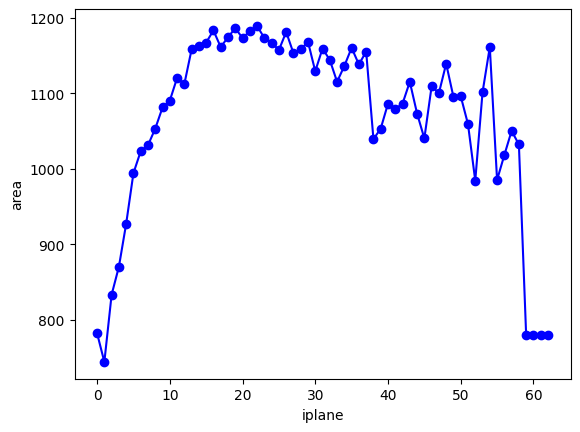

In [ ]:
mask_id = 5

#data retrieval
mask_pxs = get_area_per_plane(mask_id=mask_id,
                            mask_matrix=segmentedstacks[0].nucleus_matrix)

iplanes = [tup[0] for tup in mask_pxs]
areas = [tup[1] for tup in mask_pxs]

#plot
plt.plot(iplanes, areas, marker='o', linestyle='-', color='b')

plt.xlabel('iplane')
plt.ylabel('area')

plt.show();

In [ ]:
tuple_max_area = max(mask_pxs, key=lambda tup: tup[1]) #(iplane, area) where area is max
iplane = tuple_max_area[0]
print(iplane)

max_mask_px = get_mask_px_coords(segmentedstacks[0].nucleus_matrix[iplane, :, :], mask_id)
x0 = np.min(max_mask_px[:, 0])
x1 = np.max(max_mask_px[:, 0])
y0 = np.min(max_mask_px[:, 1])
y1 = np.max(max_mask_px[:, 1])
print(x0, x1, y0, y1)

22
327 370 57 99


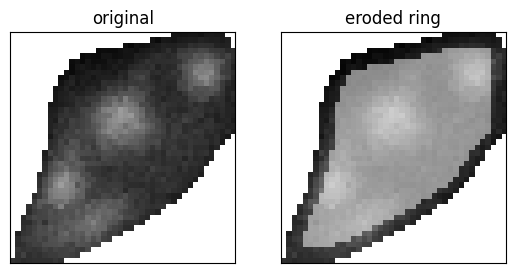

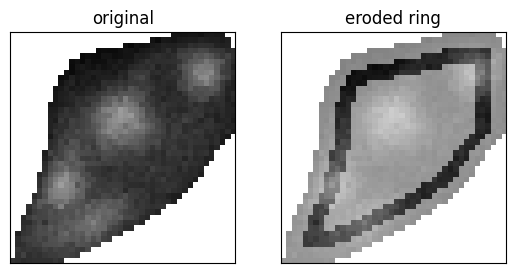

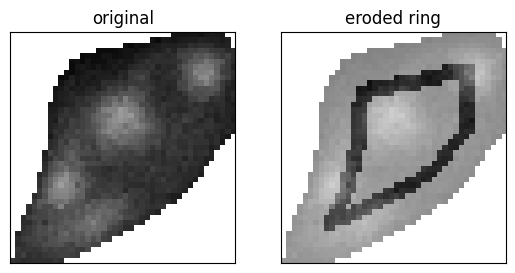

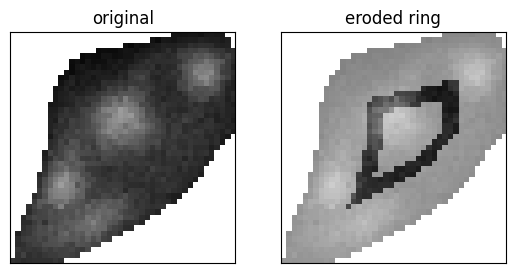

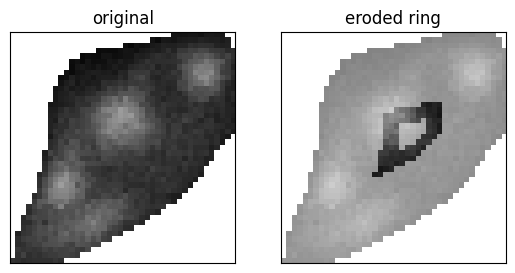

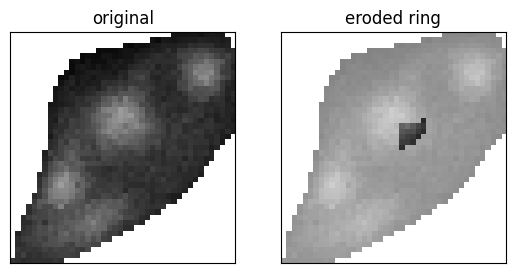

In [ ]:
from scipy import ndimage

#settings
erosion_iterations = 3 #ring width
channel = 0
#mask_id=4

#data retrieval
bbox_img_matrix = segmentedstacks[0].img_matrix[iplane, x0:x1, y0:y1, :]
bbox_nucleus_matrix = segmentedstacks[0].nucleus_matrix[iplane, x0:x1, y0:y1] == mask_id
nucleus_mask = np.ma.masked_where(bbox_nucleus_matrix == 0, bbox_img_matrix[:, :, channel])
processing_mask = nucleus_mask.copy()

#initialisation for erosion
erosion_list = [processing_mask] #elements: the nucleus mask with increasing erosion (e.g., ele0: original, ele1: after 1 erosion, ele2: after 2 erosion, ...)
eroded_ring_list = [] #elements: only the eroded ring
intensity_list = [] #elements: 1d array of intensity per eroded ring
relative_intensity_sums = [] #elements: sum of relative intensity (scaled to 0-255) per eroded ring

#erode until the center is reached
idx=0
while np.sum(processing_mask) > 0:

    #apply erosion
    binary_mask = ~processing_mask.mask
    eroded_binary_mask = ndimage.binary_erosion(binary_mask, iterations = erosion_iterations)
    eroded_masked_array = np.ma.array(processing_mask.data, mask=~eroded_binary_mask)
    erosion_list.append(eroded_masked_array)

    #retrieve the ring that has been eroded
    eroded_ring_mask = processing_mask.mask != eroded_masked_array.mask
    eroded_ring_img = processing_mask.copy()
    eroded_ring_img[~eroded_ring_mask] = 0
    eroded_ring_list.append(eroded_ring_img)

    ring_coords=np.column_stack(np.where(eroded_ring_mask))

    #intensity analysis
    intensity_list.append(eroded_ring_img.flatten())
    #sum of intensity divided by the maximum possible sum (i.e. number of pixels * max value; in this case 255)
    relative_intensity_sum = sum(eroded_ring_img.flatten()) / (np.sum(eroded_ring_mask)*255) * 100
    relative_intensity_sums.append(relative_intensity_sum)

    #visualisation
    plt.subplot(1,2,1)
    plt.imshow(nucleus_mask, cmap='gray', vmin=0, vmax=255)
    plt.xticks([]); plt.yticks([])
    plt.title("original")

    plt.subplot(1,2,2)
    plt.imshow(nucleus_mask, cmap='gray', vmin=0, vmax=255)

    test=eroded_ring_img.copy()
    test[test==0] = 255
    plt.imshow(test, cmap='gray', alpha=0.5)
    plt.xticks([]); plt.yticks([])
    plt.title("eroded ring")

    plt.savefig(f'ring{"0"+str(idx) if idx < 10 else idx}')
    # Show plot
    plt.show()

    #update the processing mask
    processing_mask = eroded_masked_array.copy()
    idx +=1

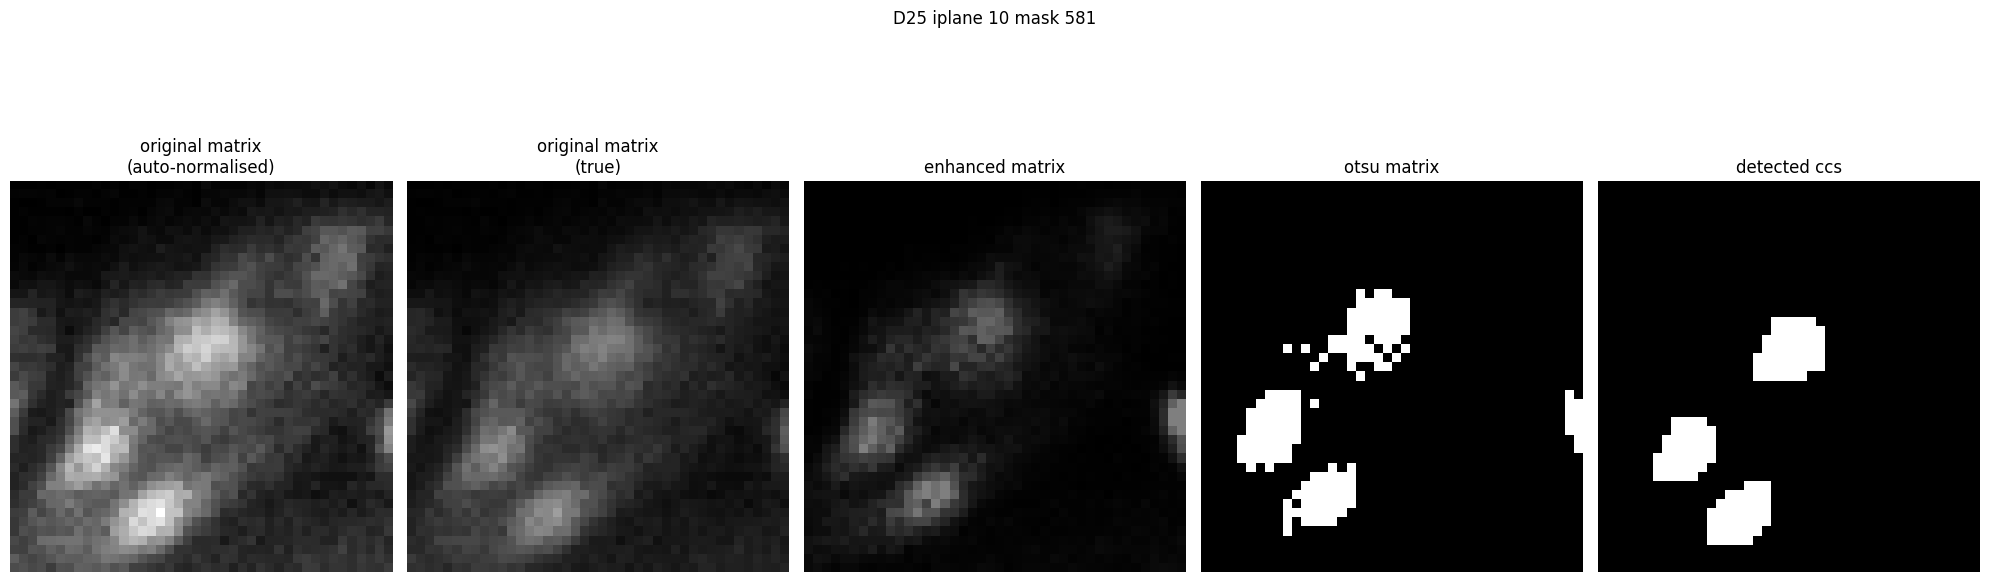

In [ ]:
#@markdown plot zoomed in section in mask
iplane=10
plt.figure(figsize=(5*4, 7))
plt.subplot(1,5,1)
mask_show = segmentedstacks[0].img_matrix
boolean_mask = mask_show[iplane, x0:x1, y0:y1, 0]
plt.imshow(boolean_mask, cmap='gray')#, vmin=0, vmax=255)
plt.axis("off")
plt.title("original matrix\n(auto-normalised)")

plt.subplot(1,5,2)
mask_show = segmentedstacks[0].img_matrix
boolean_mask = mask_show[iplane, x0:x1, y0:y1, 0]
plt.imshow(boolean_mask, cmap='gray', vmin=0, vmax=255)
plt.axis("off")
plt.title("original matrix\n(true)")

plt.subplot(1,5,3)
mask_show = skimage.io.imread('/content/SPE_20230327_D25_!full_enhanced-matrix.tiff')
boolean_mask = mask_show[iplane, x0:x1, y0:y1]
plt.imshow(boolean_mask, cmap='gray', vmin=0, vmax=255)
plt.axis("off")
plt.title("enhanced matrix")

plt.subplot(1,5,4)
mask_show = skimage.io.imread('/content/SPE_20230327_D25_!full_otsu-matrix.tiff')
boolean_mask = mask_show[iplane, x0:x1, y0:y1]
plt.imshow(boolean_mask, cmap='gray')
plt.axis("off")
plt.title("otsu matrix")

plt.subplot(1,5,5)
boolean_mask = segmentedstacks[0].chromocenter_matrix[iplane, x0:x1, y0:y1] != 0
plt.imshow(boolean_mask, cmap='gray')
plt.axis("off")
plt.title("detected ccs")

plt.suptitle(f"{segmentedstacks[0].name} iplane {iplane} mask 581", y=1)
plt.tight_layout()
plt.show()

In [ ]:
from scipy import ndimage
verbose=False
plot=False
print(f"{datetime.now()}\tStarted processing")

#settings
erosion_iterations = 1 #ring width

#initialise dataframe
df = pd.DataFrame(columns=['timepoint', 'nucleus_id', 'nuclear_volume',
                           'n_chromocenters', "iplane", "x0,x1,y0,y1",
                           "ring_coords_list", "ring_sizes", "observed_sum_radial_intensity_0",
                           "observed_sum_radial_intensity_1","observed_sum_radial_intensity_2"])

for segmentedstack in segmentedstacks:
    #retrieve analysed ids
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    for i, nucleus_id in enumerate(analysed_nucleus_ids, 1):
        print(f'\r{datetime.now()}\tProcessing {segmentedstack.name} - {i/len(analysed_nucleus_ids)*100}%', end='')

        nuclear_volume = np.sum(segmentedstack.nucleus_matrix == nucleus_id)
        n_chromocenters = segmentedstack.nucleus_dict[nucleus_id].n_chromocenters

        #get the plane with the biggest area
        mask_pxs = get_area_per_plane(mask_id=nucleus_id,
                                      mask_matrix=segmentedstack.nucleus_matrix.copy())
        tuple_max_area = max(mask_pxs, key=lambda tuple_iplane_area: tuple_iplane_area[1])
        iplane = tuple_max_area[0]

        #get bounding window
        max_mask_px = get_mask_px_coords(segmentedstack.nucleus_matrix[iplane, :, :], nucleus_id)
        x0 = np.min(max_mask_px[:, 0])
        x1 = np.max(max_mask_px[:, 0])
        y0 = np.min(max_mask_px[:, 1])
        y1 = np.max(max_mask_px[:, 1])

        #data retrieval
        bbox_img_matrix = segmentedstack.img_matrix[iplane, x0:x1, y0:y1, :]
        bbox_nucleus_matrix = segmentedstack.nucleus_matrix[iplane, x0:x1, y0:y1] == nucleus_id

        #loop through channels
        observed_sum_radial_intensity_dict = {}
        relative_max_intensities = []

        for ichannel in range(bbox_img_matrix.shape[-1]): #channel info in last dimension
            nucleus_mask = np.ma.masked_where(bbox_nucleus_matrix == 0, bbox_img_matrix[:, :, ichannel])
            processing_mask = nucleus_mask.copy()

            relative_max_intensity = np.max(processing_mask)
            #print(relative_max_intensity)

            #initialisation for erosion
            erosion_list = [processing_mask] #elements: the nucleus mask with increasing erosion (e.g., ele0: original, ele1: after 1 erosion, ele2: after 2 erosion, ...)
            eroded_ring_list = [] #elements: px of the eroded ring
            intensity_list = [] #elements: 1d array of intensity per eroded ring
            ring_coords_list = []
            ring_sizes = []
            absolute_intensity_sums = []

            #erode until the center is reached
            while np.sum(processing_mask) > 0:

                #apply erosion
                binary_mask = ~processing_mask.mask
                eroded_binary_mask = ndimage.binary_erosion(binary_mask, iterations = erosion_iterations)
                eroded_masked_array = np.ma.array(processing_mask.data, mask=~eroded_binary_mask)
                erosion_list.append(eroded_masked_array)

                #retrieve the ring that has been eroded
                eroded_ring_mask = processing_mask.mask != eroded_masked_array.mask
                eroded_ring_img = processing_mask.copy()
                eroded_ring_img[~eroded_ring_mask] = 0
                eroded_ring_list.append(eroded_ring_img)
                ring_coords=np.column_stack(np.where(eroded_ring_mask))
                ring_coords_list.append(ring_coords)
                ring_sizes.append(len(ring_coords))

                #intensity analysis
                intensity_list.append(eroded_ring_img.flatten())
                #sum of intensity divided by the maximum possible sum (i.e. number of pixels * max value; in this case 255)
                absolute_intensity_sums.append(sum(eroded_ring_img.flatten()))

                #relative_intensity_sum = sum(eroded_ring_img.flatten()) / (len(ring_coords)*relative_max_intensity) * 100
                #relative_intensity_sums.append(relative_intensity_sum)

                #visualisation
                if plot:
                    plt.subplot(1,3,1)
                    plt.imshow(processing_mask, cmap='gray', vmin=0, vmax=255)
                    plt.xticks([]); plt.yticks([])
                    plt.title("original")

                    plt.subplot(1,3,2)
                    plt.imshow(eroded_masked_array, cmap='gray', vmin=0, vmax=255)
                    plt.xticks([]); plt.yticks([])
                    plt.title("eroded")

                    plt.subplot(1,3,3)
                    plt.imshow(eroded_ring_img, cmap='gray', vmin=0, vmax=255)
                    plt.xticks([]); plt.yticks([])
                    plt.title("eroded ring")

                    # Show plot
                    plt.show()

                #update the processing mask
                processing_mask = eroded_masked_array.copy()

            #store
            observed_sum_radial_intensity_dict[ichannel] = absolute_intensity_sums
            relative_max_intensities.append(relative_max_intensity)

        #store in df
        df.loc[len(df)] = {'timepoint':segmentedstack.name,
                       'nucleus_id':nucleus_id,
                       'nuclear_volume':nuclear_volume,
                       'n_chromocenters':n_chromocenters,
                        "iplane":iplane,
                       "x0,x1,y0,y1":[x0,x1,y0,y1],
                           "ring_coords_list":ring_coords_list,
                           "ring_sizes":ring_sizes,
                           "relative_max_intensities":relative_max_intensities,
                           "observed_sum_radial_intensity_0":observed_sum_radial_intensity_dict[0],
                           "observed_sum_radial_intensity_1":observed_sum_radial_intensity_dict[1],
                           "observed_sum_radial_intensity_2":observed_sum_radial_intensity_dict[2]}

    print()

#report and save
display(df)
df.to_csv('./radial_intensity_stats_absolute_max_intensity.csv', index=False)
!cp /content/radial_intensity_stats_absolute_max_intensity.csv /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset

2024-05-24 09:15:33.268327	Started processing
2024-05-24 09:19:19.786239	Processing D25 - 100.0%
2024-05-24 09:24:07.193259	Processing D30 - 100.0%
2024-05-24 09:30:18.445082	Processing D35 - 100.0%
2024-05-24 09:35:47.262476	Processing D40 - 100.0%


,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_coords_list,ring_sizes,absolute_radial_intensity_0,absolute_radial_intensity_1,absolute_radial_intensity_2
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, ...","[112, 105, 100, 95, 88, 82, 75, 69, 62, 55, 48...","[4298, 4546, 4765, 4836, 4702, 4651, 4535, 437...","[9778, 10145, 9716, 8882, 7591, 6682, 5782, 50...","[4463, 4390, 4100, 3885, 3543, 2930, 2637, 217..."
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, ...","[155, 148, 142, 136, 129, 123, 115, 110, 103, ...","[6054, 5983, 6062, 6168, 6185, 6343, 6463, 658...","[16430, 17254, 16702, 15394, 13414, 11562, 964...","[7848, 8158, 7758, 7375, 6781, 6122, 5759, 533..."
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[[[0, 30], [0, 31], [0, 32], [0, 33], [0, 34],...","[126, 119, 113, 108, 102, 95, 87, 80, 72, 64, ...","[4468, 5242, 6071, 6701, 7001, 6826, 6350, 548...","[13428, 14041, 12356, 10217, 8429, 7229, 6173,...","[5086, 5248, 4826, 4423, 3999, 3555, 3239, 298..."
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[[[0, 72], [0, 73], [0, 74], [0, 75], [0, 76],...","[167, 162, 155, 151, 146, 141, 136, 130, 124, ...","[7474, 7407, 7468, 7679, 7669, 7742, 7772, 783...","[17714, 17147, 15887, 14194, 12846, 11517, 105...","[8171, 8408, 7849, 7934, 7443, 7160, 6996, 657..."
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[[[0, 35], [0, 36], [0, 37], [0, 38], [0, 39],...","[168, 161, 157, 152, 147, 143, 134, 130, 122, ...","[6166, 6227, 6531, 6656, 6669, 6627, 6523, 671...","[14438, 13685, 13031, 12190, 11458, 10708, 963...","[7735, 7491, 7316, 7216, 6940, 6534, 6532, 613..."
...,...,...,...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,50,"[699, 720, 531, 561]","[[[0, 19], [0, 20], [0, 21], [0, 22], [0, 23],...","[73, 69, 62, 58, 52, 45, 38, 28, 18, 8]","[1982, 2008, 1823, 1760, 1561, 1459, 1305, 121...","[4168, 3965, 3013, 2663, 2244, 1965, 1553, 112...","[2361, 2461, 2301, 2249, 1817, 1606, 1337, 100..."
1078,D40,528,9270,1,64,"[628, 650, 73, 92]","[[[0, 13], [0, 14], [0, 15], [1, 10], [1, 11],...","[63, 59, 53, 46, 40, 34, 26, 18, 11, 2]","[1296, 1417, 1608, 1825, 1931, 1994, 1708, 126...","[2884, 2444, 1897, 1432, 1208, 926, 651, 454, ...","[2635, 2241, 1891, 1442, 1204, 906, 639, 436, ..."
1079,D40,538,10224,2,64,"[310, 337, 290, 319]","[[[0, 14], [0, 15], [0, 16], [1, 12], [1, 13],...","[75, 69, 65, 61, 55, 50, 45, 38, 33, 27, 20, 1...","[1889, 1777, 1914, 1953, 2013, 2050, 2073, 184...","[3615, 3094, 2636, 2268, 1740, 1422, 1248, 968...","[2433, 2255, 2035, 1734, 1402, 1191, 887, 668,..."
1080,D40,561,11731,1,71,"[547, 567, 793, 824]","[[[0, 12], [0, 13], [0, 14], [0, 15], [0, 16],...","[75, 71, 67, 62, 57, 49, 45, 37, 30, 22]","[1822, 2022, 2159, 2186, 2226, 1920, 1967, 169...","[2845, 2967, 2878, 2636, 2493, 2028, 1802, 134...","[1616, 1671, 1487, 1463, 1296, 1188, 1071, 795..."


In [ ]:
df['relative_max_intensities'] = [[0,0,0]] * len(df)
df.head()

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_coords_list,ring_sizes,absolute_radial_intensity_0,absolute_radial_intensity_1,absolute_radial_intensity_2,relative_max_intensities
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, ...","[112, 105, 100, 95, 88, 82, 75, 69, 62, 55, 48...","[4298, 4546, 4765, 4836, 4702, 4651, 4535, 437...","[9778, 10145, 9716, 8882, 7591, 6682, 5782, 50...","[4463, 4390, 4100, 3885, 3543, 2930, 2637, 217...","[0, 0, 0]"
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, ...","[155, 148, 142, 136, 129, 123, 115, 110, 103, ...","[6054, 5983, 6062, 6168, 6185, 6343, 6463, 658...","[16430, 17254, 16702, 15394, 13414, 11562, 964...","[7848, 8158, 7758, 7375, 6781, 6122, 5759, 533...","[0, 0, 0]"
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[[[0, 30], [0, 31], [0, 32], [0, 33], [0, 34],...","[126, 119, 113, 108, 102, 95, 87, 80, 72, 64, ...","[4468, 5242, 6071, 6701, 7001, 6826, 6350, 548...","[13428, 14041, 12356, 10217, 8429, 7229, 6173,...","[5086, 5248, 4826, 4423, 3999, 3555, 3239, 298...","[0, 0, 0]"
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[[[0, 72], [0, 73], [0, 74], [0, 75], [0, 76],...","[167, 162, 155, 151, 146, 141, 136, 130, 124, ...","[7474, 7407, 7468, 7679, 7669, 7742, 7772, 783...","[17714, 17147, 15887, 14194, 12846, 11517, 105...","[8171, 8408, 7849, 7934, 7443, 7160, 6996, 657...","[0, 0, 0]"
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[[[0, 35], [0, 36], [0, 37], [0, 38], [0, 39],...","[168, 161, 157, 152, 147, 143, 134, 130, 122, ...","[6166, 6227, 6531, 6656, 6669, 6627, 6523, 671...","[14438, 13685, 13031, 12190, 11458, 10708, 963...","[7735, 7491, 7316, 7216, 6940, 6534, 6532, 613...","[0, 0, 0]"


In [ ]:
#add max intensity
df_row_i = 0
for segmentedstack in segmentedstacks:
    #retrieve analysed ids
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    for i, nucleus_id in enumerate(analysed_nucleus_ids, 1):
        print(f'\r{datetime.now()}\tProcessing {segmentedstack.name} - {i/len(analysed_nucleus_ids)*100}%', end='')

        nuclear_volume = np.sum(segmentedstack.nucleus_matrix == nucleus_id)
        n_chromocenters = segmentedstack.nucleus_dict[nucleus_id].n_chromocenters

        #get the plane with the biggest area
        mask_pxs = get_area_per_plane(mask_id=nucleus_id,
                                      mask_matrix=segmentedstack.nucleus_matrix.copy())
        tuple_max_area = max(mask_pxs, key=lambda tuple_iplane_area: tuple_iplane_area[1])
        iplane = tuple_max_area[0]

        #get bounding window
        max_mask_px = get_mask_px_coords(segmentedstack.nucleus_matrix[iplane, :, :], nucleus_id)
        x0 = np.min(max_mask_px[:, 0])
        x1 = np.max(max_mask_px[:, 0])
        y0 = np.min(max_mask_px[:, 1])
        y1 = np.max(max_mask_px[:, 1])

        #data retrieval
        bbox_img_matrix = segmentedstack.img_matrix[iplane, x0:x1, y0:y1, :]
        bbox_nucleus_matrix = segmentedstack.nucleus_matrix[iplane, x0:x1, y0:y1] == nucleus_id

        #loop through channels
        relative_max_intensities = []

        for ichannel in range(bbox_img_matrix.shape[-1]): #channel info in last dimension
            nucleus_mask = np.ma.masked_where(bbox_nucleus_matrix == 0, bbox_img_matrix[:, :, ichannel])
            processing_mask = nucleus_mask.copy()

            relative_max_intensity = np.max(processing_mask)
            relative_max_intensities.append(relative_max_intensity)

        #add to column of the corresponding row
        #print('\n',relative_max_intensities)
        #display(df.loc[(df['timepoint'] == segmentedstack.name) & (df['nucleus_id'] == nucleus_id)])
        df.at[df_row_i, 'relative_max_intensities'] = relative_max_intensities

        df_row_i += 1

    print()

2024-05-24 09:53:03.476140	Processing D25 - 100.0%
2024-05-24 09:56:48.819986	Processing D30 - 100.0%
2024-05-24 10:01:10.646437	Processing D35 - 88.69047619047619%

In [ ]:
df.to_csv('./radial_intensity_stats_absolute_max_intensity.csv', index=False)
!cp /content/radial_intensity_stats_absolute_max_intensity.csv /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset

NameError: name 'df' is not defined

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/radial_intensity_stats_absolute_max_intensity.csv')

#ring_coords_list col is currently useless
df.drop('ring_coords_list', axis=1, inplace=True)

#turn lists into lists. (reading from files results lists being seen as strings.)
for column in df.columns[5:]:
    try:
        df[column] = df[column].apply(eval)
    except NameError:
        pass

#init

df['relative_lamina_distance'] = None

for idx, row in df.iterrows():
    n_rings = len(row["ring_sizes"])
    df.at[idx, 'relative_lamina_distance'] = [i/n_rings for i in range(0,n_rings)]


In [ ]:
df.columns = ['timepoint', 'nucleus_id', 'nuclear_volume', 'n_chromocenters',
       'iplane', 'x0,x1,y0,y1', 'ring_sizes', 'observed_sum_radial_intensity_0',
       'observed_sum_radial_intensity_1', 'observed_sum_radial_intensity_2',
       'relative_max_intensities', 'relative_lamina_distance']

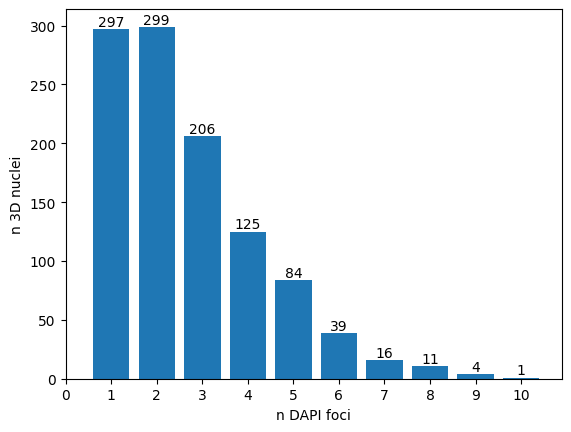

In [ ]:
nCC_dict = dict(sorted(dict(Counter(df['n_chromocenters'])).items()))

plt.bar(nCC_dict.keys(), nCC_dict.values())
plt.xlabel('n DAPI foci')
plt.ylabel('n 3D nuclei')
plt.xticks(range(0,sorted(nCC_dict.keys())[-1]+1))

for i, value in enumerate(nCC_dict.values(),1):
    plt.text(i, value, str(value), ha='center', va='bottom');

# binned rings

In [ ]:
#_user input
bin_size = 0.1

print(datetime.now(),"\tStarted processing")

#init
rebinned_df = df.copy()

#create bins
bin_list = list(np.arange(0, 1+bin_size, bin_size)) #range 0 to 1 (including 1) with stepsize = user provided

#process each row
for row_idx, row in df.iterrows():
    #print(f"\r{datetime.now()}\t\tProccesing row {row_idx}", end='')

    #initialisation
    ring_data={}

    #data retrieval
    timepoint = row['timepoint']
    distance = row['relative_lamina_distance']
    ring_sizes = row['ring_sizes']
    channel0 = row['observed_sum_radial_intensity_0']
    channel1 = row['observed_sum_radial_intensity_1']
    channel2 = row['observed_sum_radial_intensity_2']
    max_intensities = row['relative_max_intensities']

    tuple_distance_intensities = zip(distance, ring_sizes, channel0, channel1, channel2)

    #organise data into bins
    for ring_idx, ring in enumerate(tuple_distance_intensities):
        #data retrieval
        distance, ring_size, channel0, channel1, channel2 = ring
        #print(f"\tring idx {ring_idx}, distance {distance}, ring_size {ring_size}, channel0 {channel0}, channel1 {channel1}, channel2 {channel2}")

        #check in which binned ring it belongs
        for inspecting_bin in bin_list:
            if distance <= inspecting_bin:
                bin_distance=inspecting_bin
                break
        #print(f'\t\tdistance {distance} has been placed in bin {inspecting_bin:.2f}',end='\n\n')

        #store in the dictionary
        try:
            ring_data[bin_distance]['ring_sizes'].append(ring_size)
            ring_data[bin_distance]['channel0'].append(channel0)
            ring_data[bin_distance]['channel1'].append(channel1)
            ring_data[bin_distance]['channel2'].append(channel2)
        except KeyError:
            ring_data[bin_distance] = {'ring_sizes':[ring_size],
                                'channel0':[channel0],
                                'channel1':[channel1],
                                'channel2':[channel2]}

    #combine the rings into correct bins (sum the intensities)
    for binned_ring, binned_ring_data in ring_data.items():
        for k, v in binned_ring_data.items():
            binned_ring_data[k] = sum(v)

    #update df
    rebinned_df.at[row_idx, 'relative_lamina_distance'] = list(ring_data.keys())
    rebinned_df.at[row_idx, 'ring_sizes'] = [binned_ring_data['ring_sizes'] for binned_ring_data in ring_data.values()]
    rebinned_df.at[row_idx, 'observed_sum_radial_intensity_0'] = [binned_ring_data['channel0'] for binned_ring_data in ring_data.values()]
    rebinned_df.at[row_idx, 'observed_sum_radial_intensity_1'] = [binned_ring_data['channel1'] for binned_ring_data in ring_data.values()]
    rebinned_df.at[row_idx, 'observed_sum_radial_intensity_2'] = [binned_ring_data['channel2'] for binned_ring_data in ring_data.values()]

#export
rebinned_df.to_csv(f'/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/radial_intensity_stats_binned_{bin_size}.csv', index=False)

print(datetime.now(),"\tFinished processing")
display(rebinned_df.head())

2024-05-26 12:46:01.901299 	Started processing
2024-05-26 12:46:02.215775 	Finished processing


,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_sizes,observed_sum_radial_intensity_0,observed_sum_radial_intensity_1,observed_sum_radial_intensity_2,relative_max_intensities,relative_lamina_distance
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[112, 105, 195, 88, 157, 69, 117, 48, 75, 26, 10]","[4298, 4546, 9601, 4702, 9186, 4375, 7703, 304...","[9778, 10145, 18598, 7591, 12464, 5010, 7812, ...","[4463, 4390, 7985, 3543, 5567, 2179, 3681, 132...","[113, 197, 106]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[155, 148, 278, 252, 115, 213, 176, 73, 115, 7...","[6054, 5983, 12230, 12528, 6463, 12960, 11853,...","[16430, 17254, 32096, 24976, 9640, 15316, 1137...","[7848, 8158, 15133, 12903, 5759, 10166, 8017, ...","[113, 188, 91]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[126, 119, 221, 197, 87, 152, 120, 47, 67, 37, 5]","[4468, 5242, 12772, 13827, 6350, 10397, 8131, ...","[13428, 14041, 22573, 15658, 6173, 9738, 7248,...","[5086, 5248, 9249, 7554, 3239, 5498, 4077, 153...","[157, 226, 97]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[167, 162, 155, 297, 141, 266, 124, 118, 173, ...","[7474, 7407, 7468, 15348, 7742, 15606, 7747, 7...","[17714, 17147, 15887, 27040, 11517, 20028, 899...","[8171, 8408, 7849, 15377, 7160, 13575, 6109, 5...","[134, 196, 94]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[168, 161, 309, 290, 264, 238, 111, 199, 172, ...","[6166, 6227, 13187, 13296, 13233, 13124, 6603,...","[14438, 13685, 25221, 22166, 18804, 16185, 744...","[7735, 7491, 14532, 13474, 12671, 11162, 4994,...","[116, 158, 92]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."


#import from file

In [ ]:
file_path = '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/radial_intensity_stats_binned_0.1.csv'
rebinned_df = pd.read_csv(file_path)
for column in rebinned_df.columns[5:]:
    rebinned_df[column] = rebinned_df[column].apply(eval)

# Calculate intensity ratio (sum intensity / max possible)


In [ ]:
rebinned_df['ratio_radial_intensities_0'] = [[]]*len(rebinned_df)
rebinned_df['ratio_radial_intensities_1'] = [[]]*len(rebinned_df)
rebinned_df['ratio_radial_intensities_2'] = [[]]*len(rebinned_df)

for row_idx, row in rebinned_df.iterrows():

    ratio_radial_intensities_0, ratio_radial_intensities_1, ratio_radial_intensities_2 = [[],[],[]]

    for bin_id in range(len(row['relative_lamina_distance'])):
        max_sum_radial_intensity_0 = row['ring_sizes'][bin_id] * row['relative_max_intensities'][0]
        ratio_radial_intensity_0 = row['observed_sum_radial_intensity_0'][bin_id] / max_sum_radial_intensity_0
        #print('ratio_radial_intensity_0 ', ratio_radial_intensity_0)
        ratio_radial_intensities_0.append(ratio_radial_intensity_0)

        max_sum_radial_intensity_1 = row['ring_sizes'][bin_id] * row['relative_max_intensities'][1]
        ratio_radial_intensity_1 = row['observed_sum_radial_intensity_1'][bin_id] / max_sum_radial_intensity_1
        #print('ratio_radial_intensity_1 ', ratio_radial_intensity_1)
        ratio_radial_intensities_1.append(ratio_radial_intensity_1)

        max_sum_radial_intensity_2 = row['ring_sizes'][bin_id] * row['relative_max_intensities'][2]
        ratio_radial_intensity_2 = row['observed_sum_radial_intensity_2'][bin_id] / max_sum_radial_intensity_2
        #print('ratio_radial_intensity_2 ', ratio_radial_intensity_2)
        ratio_radial_intensities_2.append(ratio_radial_intensity_2)

        #if input('break') == 'y': break

    rebinned_df.at[row_idx, "ratio_radial_intensities_0"] = ratio_radial_intensities_0
    rebinned_df.at[row_idx, "ratio_radial_intensities_1"] = ratio_radial_intensities_1
    rebinned_df.at[row_idx, "ratio_radial_intensities_2"] = ratio_radial_intensities_2
#export
rebinned_df.to_csv(f'/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/radial_intensity_stats_binned_{bin_size}.csv', index=False)


In [ ]:
rebinned_df

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_sizes,observed_sum_radial_intensity_0,observed_sum_radial_intensity_1,observed_sum_radial_intensity_2,relative_max_intensities,relative_lamina_distance,ratio_radial_intensities_0,ratio_radial_intensities_1,ratio_radial_intensities_2
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[112, 105, 195, 88, 157, 69, 117, 48, 75, 26, 10]","[4298, 4546, 9601, 4702, 9186, 4375, 7703, 304...","[9778, 10145, 18598, 7591, 12464, 5010, 7812, ...","[4463, 4390, 7985, 3543, 5567, 2179, 3681, 132...","[113, 197, 106]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3396017699115044, 0.38314369995785924, 0.43...","[0.4431653372008702, 0.4904520183708001, 0.484...","[0.3759265498652291, 0.394429469901168, 0.3863..."
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[155, 148, 278, 252, 115, 213, 176, 73, 115, 7...","[6054, 5983, 12230, 12528, 6463, 12960, 11853,...","[16430, 17254, 32096, 24976, 9640, 15316, 1137...","[7848, 8158, 15133, 12903, 5759, 10166, 8017, ...","[113, 188, 91]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.34564658863831, 0.3577493422626166, 0.38931...","[0.5638297872340425, 0.6201121334100057, 0.614...","[0.556398440269408, 0.6057321057321058, 0.5981..."
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[126, 119, 221, 197, 87, 152, 120, 47, 67, 37, 5]","[4468, 5242, 12772, 13827, 6350, 10397, 8131, ...","[13428, 14041, 22573, 15658, 6173, 9738, 7248,...","[5086, 5248, 9249, 7554, 3239, 5498, 4077, 153...","[157, 226, 97]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.22586189465170356, 0.28057592463737085, 0.3...","[0.4715549936788875, 0.5220867107905109, 0.451...","[0.4161348388152512, 0.45464783851685003, 0.43..."
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[167, 162, 155, 297, 141, 266, 124, 118, 173, ...","[7474, 7407, 7468, 15348, 7742, 15606, 7747, 7...","[17714, 17147, 15887, 27040, 11517, 20028, 899...","[8171, 8408, 7849, 15377, 7160, 13575, 6109, 5...","[134, 196, 94]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3339887389400304, 0.3412106135986733, 0.359...","[0.541182940241965, 0.5400289745527841, 0.5229...","[0.5205121671550516, 0.552140793275545, 0.5387..."
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[168, 161, 309, 290, 264, 238, 111, 199, 172, ...","[6166, 6227, 13187, 13296, 13233, 13124, 6603,...","[14438, 13685, 25221, 22166, 18804, 16185, 744...","[7735, 7491, 14532, 13474, 12671, 11162, 4994,...","[116, 158, 92]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.31639983579638753, 0.3334225744270722, 0.36...","[0.5439270644966847, 0.5379746835443038, 0.516...","[0.5004528985507246, 0.5057385903321631, 0.511..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,50,"[699, 720, 531, 561]","[73, 69, 62, 58, 52, 45, 38, 28, 18, 8]","[1982, 2008, 1823, 1760, 1561, 1459, 1305, 121...","[4168, 3965, 3013, 2663, 2244, 1965, 1553, 112...","[2361, 2461, 2301, 2249, 1817, 1606, 1337, 100...","[102, 94, 72]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.26618318560300835, 0.28530832622904234, 0.2...","[0.6074030894782863, 0.6113166820844896, 0.516...","[0.4492009132420091, 0.49537037037037035, 0.51..."
1078,D40,528,9270,1,64,"[628, 650, 73, 92]","[63, 59, 53, 46, 40, 34, 26, 18, 11, 2]","[1296, 1417, 1608, 1825, 1931, 1994, 1708, 126...","[2884, 2444, 1897, 1432, 1208, 926, 651, 454, ...","[2635, 2241, 1891, 1442, 1204, 906, 639, 436, ...","[183, 103, 90]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.11241217798594848, 0.13124015930351024, 0.1...","[0.4444444444444444, 0.40217212440348854, 0.34...","[0.46472663139329806, 0.42203389830508475, 0.3..."
1079,D40,538,10224,2,64,"[310, 337, 290, 319]","[75, 69, 65, 116, 50, 83, 33, 27, 35, 9, 2]","[1889, 1777, 1914, 3966, 2050, 3914, 1529, 122...","[3615, 3094, 2636, 4008, 1422, 2216, 815, 675,...","[2433, 2255, 2035, 3136, 1191, 1555, 678, 507,...","[105, 107, 80]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..

In [ ]:
file_path = '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset/radial_intensity_stats_binned_0.1.csv'
rebinned_df = pd.read_csv(file_path)
for column in rebinned_df.columns[5:]:
    rebinned_df[column] = rebinned_df[column].apply(eval)

rebinned_df

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_sizes,observed_sum_radial_intensity_0,observed_sum_radial_intensity_1,observed_sum_radial_intensity_2,relative_max_intensities,relative_lamina_distance,ratio_radial_intensities_0,ratio_radial_intensities_1,ratio_radial_intensities_2
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[112, 105, 195, 88, 157, 69, 117, 48, 75, 26, 10]","[4298, 4546, 9601, 4702, 9186, 4375, 7703, 304...","[9778, 10145, 18598, 7591, 12464, 5010, 7812, ...","[4463, 4390, 7985, 3543, 5567, 2179, 3681, 132...","[113, 197, 106]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3396017699115044, 0.38314369995785924, 0.43...","[0.4431653372008702, 0.4904520183708001, 0.484...","[0.3759265498652291, 0.394429469901168, 0.3863..."
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[155, 148, 278, 252, 115, 213, 176, 73, 115, 7...","[6054, 5983, 12230, 12528, 6463, 12960, 11853,...","[16430, 17254, 32096, 24976, 9640, 15316, 1137...","[7848, 8158, 15133, 12903, 5759, 10166, 8017, ...","[113, 188, 91]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.34564658863831, 0.3577493422626166, 0.38931...","[0.5638297872340425, 0.6201121334100057, 0.614...","[0.556398440269408, 0.6057321057321058, 0.5981..."
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[126, 119, 221, 197, 87, 152, 120, 47, 67, 37, 5]","[4468, 5242, 12772, 13827, 6350, 10397, 8131, ...","[13428, 14041, 22573, 15658, 6173, 9738, 7248,...","[5086, 5248, 9249, 7554, 3239, 5498, 4077, 153...","[157, 226, 97]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.22586189465170356, 0.28057592463737085, 0.3...","[0.4715549936788875, 0.5220867107905109, 0.451...","[0.4161348388152512, 0.45464783851685003, 0.43..."
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[167, 162, 155, 297, 141, 266, 124, 118, 173, ...","[7474, 7407, 7468, 15348, 7742, 15606, 7747, 7...","[17714, 17147, 15887, 27040, 11517, 20028, 899...","[8171, 8408, 7849, 15377, 7160, 13575, 6109, 5...","[134, 196, 94]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3339887389400304, 0.3412106135986733, 0.359...","[0.541182940241965, 0.5400289745527841, 0.5229...","[0.5205121671550516, 0.552140793275545, 0.5387..."
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[168, 161, 309, 290, 264, 238, 111, 199, 172, ...","[6166, 6227, 13187, 13296, 13233, 13124, 6603,...","[14438, 13685, 25221, 22166, 18804, 16185, 744...","[7735, 7491, 14532, 13474, 12671, 11162, 4994,...","[116, 158, 92]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.31639983579638753, 0.3334225744270722, 0.36...","[0.5439270644966847, 0.5379746835443038, 0.516...","[0.5004528985507246, 0.5057385903321631, 0.511..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,50,"[699, 720, 531, 561]","[73, 69, 62, 58, 52, 45, 38, 28, 18, 8]","[1982, 2008, 1823, 1760, 1561, 1459, 1305, 121...","[4168, 3965, 3013, 2663, 2244, 1965, 1553, 112...","[2361, 2461, 2301, 2249, 1817, 1606, 1337, 100...","[102, 94, 72]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.26618318560300835, 0.28530832622904234, 0.2...","[0.6074030894782863, 0.6113166820844896, 0.516...","[0.4492009132420091, 0.49537037037037035, 0.51..."
1078,D40,528,9270,1,64,"[628, 650, 73, 92]","[63, 59, 53, 46, 40, 34, 26, 18, 11, 2]","[1296, 1417, 1608, 1825, 1931, 1994, 1708, 126...","[2884, 2444, 1897, 1432, 1208, 926, 651, 454, ...","[2635, 2241, 1891, 1442, 1204, 906, 639, 436, ...","[183, 103, 90]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.11241217798594848, 0.13124015930351024, 0.1...","[0.4444444444444444, 0.40217212440348854, 0.34...","[0.46472663139329806, 0.42203389830508475, 0.3..."
1079,D40,538,10224,2,64,"[310, 337, 290, 319]","[75, 69, 65, 116, 50, 83, 33, 27, 35, 9, 2]","[1889, 1777, 1914, 3966, 2050, 3914, 1529, 122...","[3615, 3094, 2636, 4008, 1422, 2216, 815, 675,...","[2433, 2255, 2035, 3136, 1191, 1555, 678, 507,...","[105, 107, 80]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..

In [ ]:
def show_intensity_ratio_single_nucleus(row):
    """
    row; pd. named Series
    """
    x_ticks = row['relative_lamina_distance']
    ratio_radial_intensities_0 = row['ratio_radial_intensities_0']
    plt.plot(x_ticks,row['ratio_radial_intensities_0'], color='blue', label='DAPI')
    plt.plot(x_ticks,row['ratio_radial_intensities_1'], color='green', label='LaminB1')
    plt.plot(x_ticks,row['ratio_radial_intensities_2'], color='red', label='H3K4me3')

    #plt.xticks(range(0,1))
    plt.yticks(np.arange(0,1.2,0.2))

    plt.title(f"nucleus {row['nucleus_id']} (nCC={row['n_chromocenters']})")
    plt.legend()
    plt.show();


In [ ]:
import random
for i in random.sample(list(rebinned_df.index), 3):
    show_intensity_ratio_single_nucleus(rebinned_df.iloc[i])

NameError: name 'rebinned_df' is not defined

#radial intensity using rebinned rings

In [ ]:
def compile_intensities(bin_df, class_column):
    print(f'{datetime.now()}\tStarted processing')
    print(f'{datetime.now()}\t\tdetected classes: {np.unique(bin_df[class_column])})')

    #initialise
    compiled_intensities = {}

    for single_class in np.unique(bin_df[class_column]):
        print(f'{datetime.now()}\t\tprocessing {single_class}')

        #initialise dict for compilation
        class_intensities_dict = {} #{bin : {channel : [intensity row1, intensity row2, ...]}}

        #get all rows of the single class
        class_df = bin_df[bin_df[class_column]==single_class].reset_index(drop=True)
        #display(class_df)

        #compile all datapoints from rows in the bins into a dict
        for row_idx, row in class_df.iterrows():
            for bin_idx, distance_bin in enumerate(row['relative_lamina_distance']):

                #init
                if distance_bin not in class_intensities_dict:
                    channels = [0,1,2]
                    class_intensities_dict[distance_bin] = {f"channel{channel}" : [] for channel in channels}

                #store all observed ratios for each bin into a dict per channel
                for channel in channels:
                    try:
                        class_intensities_dict[distance_bin][f"channel{channel}"].append(row[f'ratio_radial_intensities_{channel}'][bin_idx])
                    except NameError:
                        class_intensities_dict[distance_bin][f"channel{channel}"] = [row[f'ratio_radial_intensities_{channel}'][bin_idx]]

        compiled_intensities[single_class] = class_intensities_dict

    print(f'{datetime.now()}\tFinished processing')
    return compiled_intensities

In [ ]:
bin_df = rebinned_df
class_column = 'timepoint'
compiled_intensities = compile_intensities(bin_df, class_column)


2024-05-27 06:06:27.347195	Started processing
2024-05-27 06:06:27.348386		detected classes: ['D25' 'D30' 'D35' 'D40'])
2024-05-27 06:06:27.350053		processing D25
2024-05-27 06:06:27.395244		processing D30
2024-05-27 06:06:27.445987		processing D35
2024-05-27 06:06:27.501703		processing D40
2024-05-27 06:06:27.547459	Finished processing


# calculate the median

In [ ]:
def get_summary_intensities_per_class(compiled_intensities):
    """
    dict: {CLASS : {BIN : {CHANNEL: {SUMMARY STAT* : FLOAT}}}

        *where summary stat: 25%, 50%, 75%, count, mean, max, min
    """
    summary_intensity_df = pd.DataFrame(columns=['class','channel', 'bin','count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
    for single_class, bin_dict in compiled_intensities.items():
        for single_bin, channel_dict in bin_dict.items():
            for single_channel, intensity_list in channel_dict.items():
                class_intensity_df = pd.Series(intensity_list).describe().to_frame().T
                class_intensity_df['class'] = single_class
                class_intensity_df['bin'] = single_bin
                class_intensity_df['channel'] = single_channel

                summary_intensity_df =  pd.concat([summary_intensity_df, class_intensity_df], ignore_index=True)
    return summary_intensity_df

In [ ]:
display(summary_intensity_df.head())

,class,channel,bin,count,mean,std,min,25%,50%,75%,max
0,D25,channel0,0.0,214.0,0.230232,0.066594,0.117427,0.179004,0.225509,0.273709,0.433373
1,D25,channel1,0.0,214.0,0.492467,0.075926,0.283468,0.441331,0.501598,0.543974,0.689712
2,D25,channel2,0.0,214.0,0.436495,0.065692,0.235747,0.397768,0.437543,0.480983,0.644981
3,D25,channel0,0.1,213.0,0.256539,0.064046,0.138885,0.207368,0.253840,0.304186,0.432904
4,D25,channel1,0.1,213.0,0.538590,0.072740,0.334818,0.492293,0.541243,0.591978,0.726378


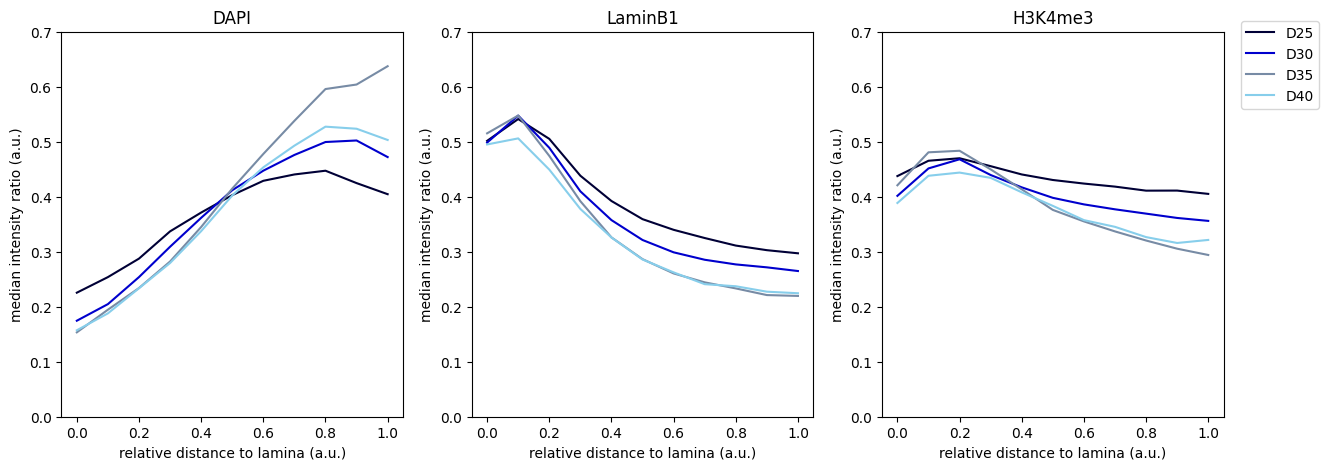

In [ ]:
from pprint import pprint

#_user input
summary_intensity_df = get_summary_intensities_per_class(compiled_intensities)
selected_class = 'channel'
selected_div = 'class'
selected_statistic='50%'
selected_statistic_name = 'median'
fill=False

color_dict = {'channel0': 'blue',
              'channel1': 'green',
              'channel2': 'red',
              'D25':'#000036',
              'D30':'#0000cd',
              'D35':'#778ba5',
              'D40':'#87ceeb'}
legend_dict = {'channel0': 'DAPI',
              'channel1': 'LaminB1',
              'channel2': 'H3K4me3'}
class_dict = {'channel0': 'DAPI',
              'channel1': 'LaminB1',
              'channel2': 'H3K4me3'}
#_processing
classes = np.unique(summary_intensity_df[selected_class])
plt.figure(figsize=(len(classes)*5,5))
for class_idx, single_class in enumerate(classes,1):
    plt.subplot(1,len(classes), class_idx)

    class_df = summary_intensity_df[summary_intensity_df[selected_class] == single_class]

    for single_channel in np.unique(class_df[selected_div]):
        channel_df = class_df[class_df[selected_div] == single_channel].sort_values(by=['bin'])

        plt.plot(channel_df['bin'],
                 channel_df[selected_statistic],
                 color=color_dict[single_channel],
                 label=legend_dict.get(single_channel, single_channel))

        if fill:
            plt.fill_between(channel_df['bin'], y1=channel_df['25%'], y2=channel_df['75%'],
                         color=color_dict[single_channel], alpha=0.08)

    plt.ylim(0, 0.7)
    plt.xlabel('relative distance to lamina (a.u.)')
    plt.ylabel(f'{selected_statistic_name} intensity ratio (a.u.)')

    plt.title(f'{class_dict.get(single_class, single_class)}')

plt.legend(loc=(1.05,0.8))
plt.show();

#Show nucleus

In [ ]:
rebinned_df

,timepoint,nucleus_id,nuclear_volume,n_chromocenters,iplane,"x0,x1,y0,y1",ring_sizes,observed_sum_radial_intensity_0,observed_sum_radial_intensity_1,observed_sum_radial_intensity_2,relative_max_intensities,relative_lamina_distance,ratio_radial_intensities_0,ratio_radial_intensities_1,ratio_radial_intensities_2
0,D25,2,64337,2,35,"[238, 279, 0, 29]","[112, 105, 195, 88, 157, 69, 117, 48, 75, 26, 10]","[4298, 4546, 9601, 4702, 9186, 4375, 7703, 304...","[9778, 10145, 18598, 7591, 12464, 5010, 7812, ...","[4463, 4390, 7985, 3543, 5567, 2179, 3681, 132...","[113, 197, 106]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3396017699115044, 0.38314369995785924, 0.43...","[0.4431653372008702, 0.4904520183708001, 0.484...","[0.3759265498652291, 0.394429469901168, 0.3863..."
1,D25,4,58079,1,23,"[323, 387, 988, 1023]","[155, 148, 278, 252, 115, 213, 176, 73, 115, 7...","[6054, 5983, 12230, 12528, 6463, 12960, 11853,...","[16430, 17254, 32096, 24976, 9640, 15316, 1137...","[7848, 8158, 15133, 12903, 5759, 10166, 8017, ...","[113, 188, 91]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.34564658863831, 0.3577493422626166, 0.38931...","[0.5638297872340425, 0.6201121334100057, 0.614...","[0.556398440269408, 0.6057321057321058, 0.5981..."
2,D25,5,67305,8,22,"[327, 370, 57, 99]","[126, 119, 221, 197, 87, 152, 120, 47, 67, 37, 5]","[4468, 5242, 12772, 13827, 6350, 10397, 8131, ...","[13428, 14041, 22573, 15658, 6173, 9738, 7248,...","[5086, 5248, 9249, 7554, 3239, 5498, 4077, 153...","[157, 226, 97]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.22586189465170356, 0.28057592463737085, 0.3...","[0.4715549936788875, 0.5220867107905109, 0.451...","[0.4161348388152512, 0.45464783851685003, 0.43..."
3,D25,6,57671,4,32,"[342, 389, 121, 200]","[167, 162, 155, 297, 141, 266, 124, 118, 173, ...","[7474, 7407, 7468, 15348, 7742, 15606, 7747, 7...","[17714, 17147, 15887, 27040, 11517, 20028, 899...","[8171, 8408, 7849, 15377, 7160, 13575, 6109, 5...","[134, 196, 94]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.3339887389400304, 0.3412106135986733, 0.359...","[0.541182940241965, 0.5400289745527841, 0.5229...","[0.5205121671550516, 0.552140793275545, 0.5387..."
4,D25,7,124805,4,38,"[348, 386, 944, 1011]","[168, 161, 309, 290, 264, 238, 111, 199, 172, ...","[6166, 6227, 13187, 13296, 13233, 13124, 6603,...","[14438, 13685, 25221, 22166, 18804, 16185, 744...","[7735, 7491, 14532, 13474, 12671, 11162, 4994,...","[116, 158, 92]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.31639983579638753, 0.3334225744270722, 0.36...","[0.5439270644966847, 0.5379746835443038, 0.516...","[0.5004528985507246, 0.5057385903321631, 0.511..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,D40,519,7079,1,50,"[699, 720, 531, 561]","[73, 69, 62, 58, 52, 45, 38, 28, 18, 8]","[1982, 2008, 1823, 1760, 1561, 1459, 1305, 121...","[4168, 3965, 3013, 2663, 2244, 1965, 1553, 112...","[2361, 2461, 2301, 2249, 1817, 1606, 1337, 100...","[102, 94, 72]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.26618318560300835, 0.28530832622904234, 0.2...","[0.6074030894782863, 0.6113166820844896, 0.516...","[0.4492009132420091, 0.49537037037037035, 0.51..."
1078,D40,528,9270,1,64,"[628, 650, 73, 92]","[63, 59, 53, 46, 40, 34, 26, 18, 11, 2]","[1296, 1417, 1608, 1825, 1931, 1994, 1708, 126...","[2884, 2444, 1897, 1432, 1208, 926, 651, 454, ...","[2635, 2241, 1891, 1442, 1204, 906, 639, 436, ...","[183, 103, 90]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[0.11241217798594848, 0.13124015930351024, 0.1...","[0.4444444444444444, 0.40217212440348854, 0.34...","[0.46472663139329806, 0.42203389830508475, 0.3..."
1079,D40,538,10224,2,64,"[310, 337, 290, 319]","[75, 69, 65, 116, 50, 83, 33, 27, 35, 9, 2]","[1889, 1777, 1914, 3966, 2050, 3914, 1529, 122...","[3615, 3094, 2636, 4008, 1422, 2216, 815, 675,...","[2433, 2255, 2035, 3136, 1191, 1555, 678, 507,...","[105, 107, 80]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..

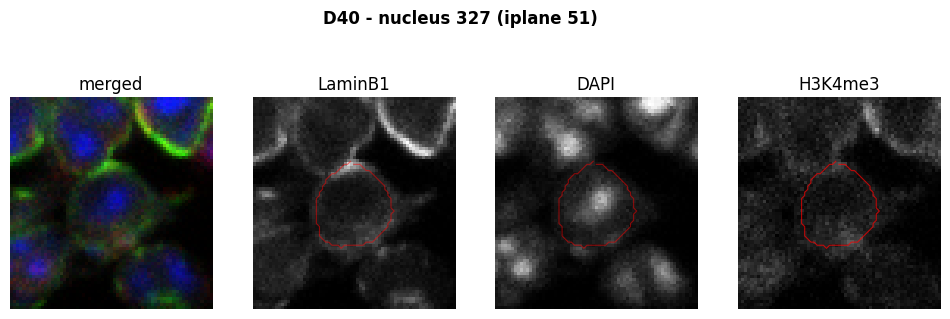

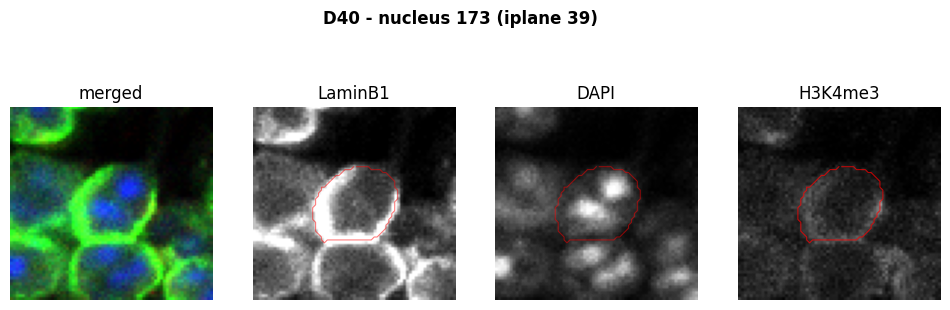

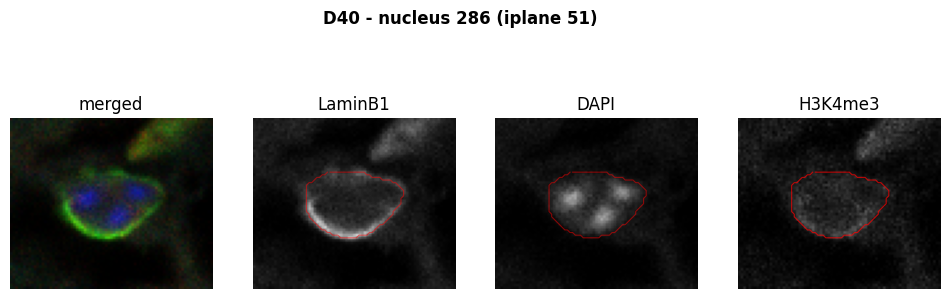

In [ ]:
import random
from matplotlib.colors import LinearSegmentedColormap

segmentedstack = segmentedstacks[3]
nrandom=3
padding=20


#processing
selected_timepoint=segmentedstack.name
nucleus_ids = random.sample(list(rebinned_df[(rebinned_df['timepoint']==selected_timepoint)]['nucleus_id']),nrandom)

for nucleus_id in nucleus_ids:
    plt.figure(figsize=(12,4))
    row = rebinned_df[(rebinned_df['timepoint']==selected_timepoint) &
                       (rebinned_df['nucleus_id']==nucleus_id)]
    iplane=row['iplane'].iloc[0]

    x0,x1,y0,y1 = row['x0,x1,y0,y1'].iloc[0]

    #include padding
    xmax, ymax = segmentedstack.img_matrix.shape[1:-1]
    x0 = max(0, x0-padding)
    x1 = min(xmax, x1+padding)
    y0 = max(0, y0-padding)
    y1 = min(ymax, y1+padding)

    #get matrices
    img_matrix = segmentedstack.img_matrix[:, x0:x1, y0:y1, :].copy()
    nucleus_matrix = segmentedstack.nucleus_matrix[:, x0:x1, y0:y1].copy()
    chromocenter_matrix = segmentedstack.chromocenter_matrix[:, x0:x1, y0:y1].copy()
    #print("unique chromocenter_matrix", np.unique(chromocenter_matrix))

    #retain only the segmentation of the inspected nucleus
    nucleus_matrix[nucleus_matrix != nucleus_id] = 0

    #plot
    plt.subplot(1,4,1)
    plt.imshow(np.dstack(tuple(img_matrix[iplane, :, :, i] for i in [2,1,0])))
    plt.grid("off")
    plt.axis("off")
    plt.title("merged")

    plt.subplot(1,4,2)
    plt.imshow(img_matrix[iplane, :, :, 1], vmin=0, vmax=255, cmap='gray')
    for o in outlines_list(nucleus_matrix[iplane]):
        plt.plot(o[:,0], o[:,1], color='red', linewidth=0.8, alpha=0.5)
    plt.grid("off")
    plt.axis("off")
    plt.title("LaminB1")

    plt.subplot(1,4,3)
    plt.imshow(img_matrix[iplane, :, :, 0], vmin=0, vmax=255, cmap='gray')

    for o in outlines_list(nucleus_matrix[iplane]):
        plt.plot(o[:,0], o[:,1], color='red', linewidth=0.8, alpha=0.5)

    plt.grid("off")
    plt.axis("off")
    plt.title("DAPI")

    plt.subplot(1,4,4)
    plt.imshow(img_matrix[iplane, :, :, 2], vmin=0, vmax=255, cmap='gray')
    plt.grid("off")
    plt.axis("off")
    plt.title("H3K4me3")

    for o in outlines_list(nucleus_matrix[iplane]):
        plt.plot(o[:,0], o[:,1], color='red', linewidth=0.8, alpha=0.7)

    plt.suptitle(f"{segmentedstack.name} - nucleus {nucleus_id} (iplane {iplane})",
                weight='bold')

#Incorporating fullness
dev: assumes the logdiff_df file is stored as `f"/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/06_QC_matrices/logfold_differences/{segmentedstack.name}.csv"`

In [ ]:
logfold_dict = {}
for segmentedstack in segmentedstacks:
    #data retrieval
    logfold_diffs_df = pd.read_csv(f"/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/06_QC_matrices/logfold_differences/{segmentedstack.name}.csv")
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    #store data
    filtered_df = logfold_diffs_df[logfold_diffs_df['label_id'].isin(analysed_nucleus_ids)]
    logfold_dict[segmentedstack.name] = logfold_diffs_df


NameError: name 'analysed_nuclei_dict' is not defined

In [ ]:
logfold_df

,label_id,biggest_iplane,Vi_O,Vi_E,Vi_E_norm,log2fold
0,870.0,90.0,283.0,3533.274179,68898.846493,-7.927534
1,865.0,89.0,495.0,8842.039832,238735.075469,-8.913766
2,850.0,88.0,522.0,9595.945178,263888.492384,-8.981663
3,839.0,87.0,523.0,9220.254651,248946.875578,-8.894811
4,838.0,87.0,258.0,3104.207653,58979.945412,-7.836710
...,...,...,...,...,...,...
426,5.0,26.0,30358.0,11429.811439,5922.720473,2.357745
427,4.0,28.0,31874.0,11599.403716,5425.527544,2.554545
428,3.0,56.0,60797.0,16271.280370,5811.171561,3.387099
429,2.0,23.0,25065.0,21483.103905,34817.444260,-0.474136


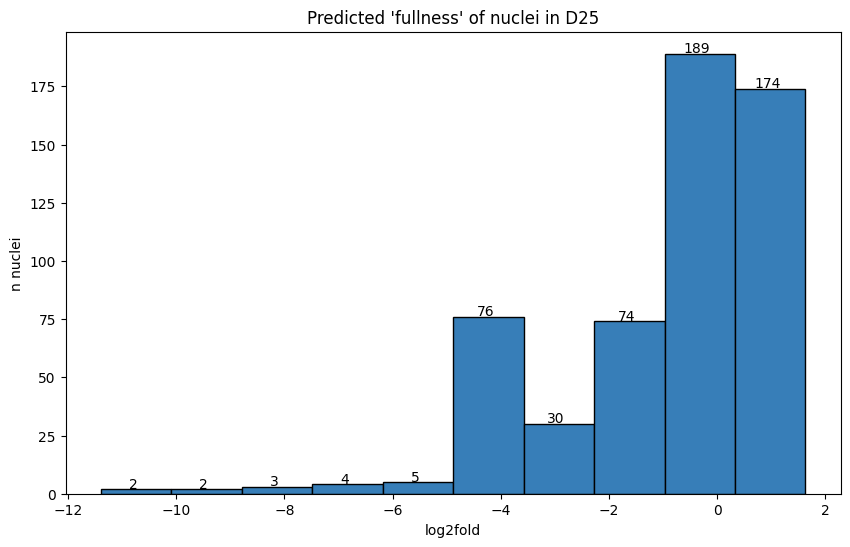

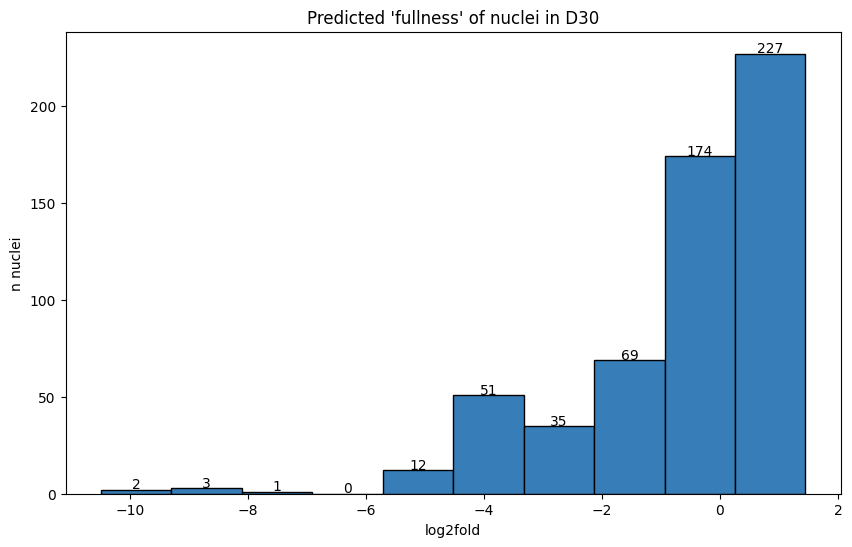

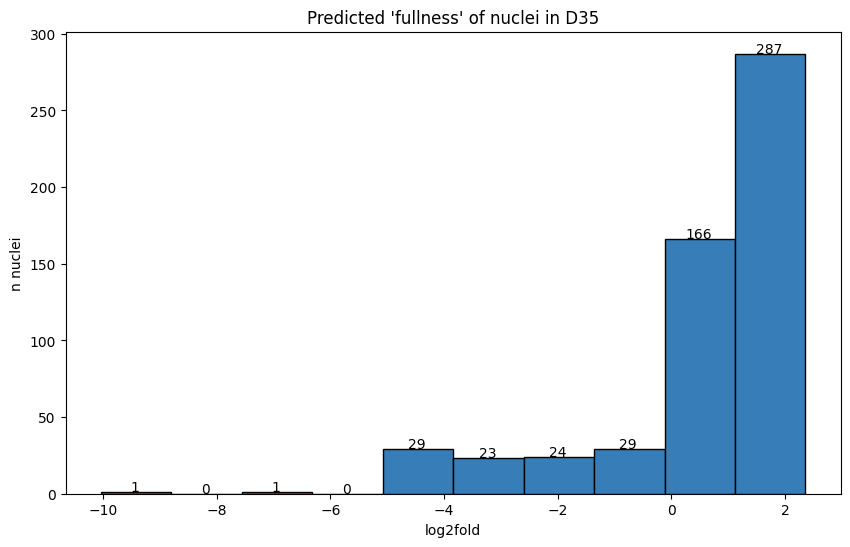

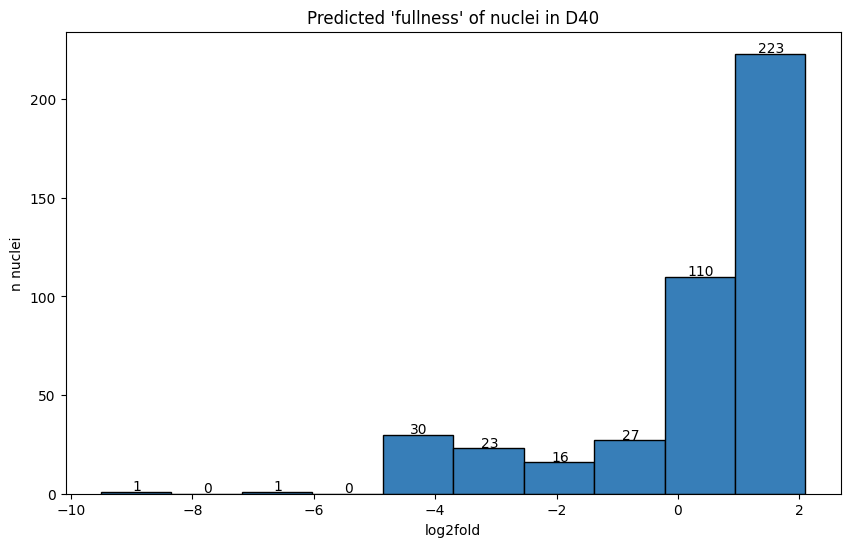

In [ ]:
for timepoint, logfold_df in logfold_dict.items():

    logfold_diffs = np.log2(logfold_df['Vi_O']/logfold_df['Vi_E']) #using non-normalised Vi_E
    #logfold_diffs = logfold_df['log2fold'] #using normalised Vi_E

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(logfold_diffs, color="#377eb8", edgecolor='black')
    plt.xlabel('log2fold')
    plt.ylabel('n nuclei')
    plt.title(f"Predicted 'fullness' of nuclei in {timepoint}")

    # Add count above each bar
    for count, x, patch in zip(n, bins, patches):
        plt.text(x+0.6, count+0.5, str(int(count)), ha='center')

    plt.show()

In [ ]:
for timepoint, logfold_df in logfold_dict.items():
    display(logfold_df)

#Export matrices


Options;
- filtered (i.e. only keeping `analysed_nucleus_ids`)
- colourcoded by trait (number of predicted CCs)


In [ ]:
#@markdown [export filtered (and optionally, renamed) matrix]

#options
by_cc_count = False #@param {type:'boolean'}
name_suffix = '_with_all_perfect_cc' #@param {type:'string'}

#change pixels to number of chromocentres in a nucleus
for segmentedstack in segmentedstacks:

    #get data
    classified_nucleus_matrix = copy.deepcopy(segmentedstack.nucleus_matrix)
    analysed_nucleus_ids = analysed_nuclei_dict[segmentedstack.name]

    #remove nuclei that are not analysed
    classified_nucleus_matrix[~np.isin(classified_nucleus_matrix, analysed_nucleus_ids)] = 0

    #set pixels based on cc count
    if by_cc_count:
        for nucleus_id in analysed_nucleus_ids:
            cc_count = segmentedstack.nucleus_dict[nucleus_id].n_chromocenters
            classified_nucleus_matrix[classified_nucleus_matrix == nucleus_id] = cc_count

    tifffile.imsave(f"{segmentedstack.name}{name_suffix}.tiff", classified_nucleus_matrix, bigtiff=True)

#zip and store in output_directory
!zip nuclei_{name_suffix}.zip *.tiff
!mv nuclei_{name_suffix}.zip /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/07_segmented_dataset

<ipython-input-67-dc399961abc2>:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f"{segmentedstack.name}{name_suffix}.tiff", classified_nucleus_matrix, bigtiff=True)


  adding: D25_with_all_perfect_cc.tiff (deflated 99%)
  adding: D25_with_zero_count.tiff (deflated 100%)
  adding: D30_with_all_perfect_cc.tiff (deflated 99%)
  adding: D30_with_zero_count.tiff (deflated 100%)
  adding: D35_with_all_perfect_cc.tiff (deflated 99%)
  adding: D35_with_zero_count.tiff (deflated 100%)
  adding: D40_with_all_perfect_cc.tiff (deflated 99%)
  adding: D40_with_zero_count.tiff (deflated 100%)
